<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/trading/perp_basis_costs_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Perpetual Futures Basis Strategy 

In this notebook, we're going to explore crypto perpetual futures. Specifically, those traded on FTX.

Holding a perpetual futures positions results in debits or credits to your account, depending on whether you're long or short, and whether the future trades at a premium to its index:
- Perpetual trades at a premium: longs pay shorts
- Perpetual trades at a discount: shorts pay longs

This is a mechanism designed to keep the future tethered to its index. 

In an efficient market, we'd expect this basis (the premium or discount of the future to the index) to converge at the end of the funding period. 

But [previous work](https://github.com/RWLab/crypto-pod/blob/main/trading/perp_basis.ipynb) showed that we actually see something quite different - we see serial correlation in the funding rate over several days. That is, funding rate tends to persist for days. 

And this leads us to a nice, simple perpetual futures basis strategy that involves being short perpetuals trading at a premium and long their underlying spot market in equal size and collecting funding credits. 

## Next steps

Here we take the perp basis strategy we explored previously and apply a deeper consideration of costs. 

In particular, many cyrpto perpetuals are illiquid with significant spreads - which means that executing the basis trade is expensive. 

We want to explore the trade-offs around costs (particularly spread), a minimum funding hurdle to make trading viable, and the resulting viable universe of perpetuals. 

The goals are to:
- define which perpetuals we should consider trading 
- improve the cost estimation 
- define a sensible funding hurdle
- understand if there are better times to execute the basis strategy (does the spread exhibit exploitable time series properties?)
- comment on an approach to sizing
- simulate the strategy with these improved inputs

## Missing tickers

At the time of writing, data for the following tickers had not been processed. Therefore these are not yet included in the spread analysis, but many of these tickers are included in the simulation on the basis of knowing how liquid they are. 

I expect to have these processed in the next 24 hours.

'1INCH-PERP',  'BTC-PERP',  'ETH-PERP',    'BCH-PERP', 'BNB-PERP',   'LINK-PERP','MATIC-PERP', 'MKR-PERP','MTA-PERP','OKB-PERP', 'OMG-PERP','PAXG-PERP','RUNE-PERP','SOL-PERP','SUSHI-PERP', 'SXP-PERP', 'TOMO-PERP','TRX-PERP', 'UNI-PERP','WAVES-PERP', 'XAUT-PERP', 'XRP-PERP'

## Setup and load libraries

In [1]:
# snippet: rw load rwrtools for crypto pod v0.2 (currently in beta - please test!)

# lists of libraries: rwRtools dependencies (install but don't load) and libs_to_load (install and load)
dependencies <- c(
  "pacman", "ttr", "googleauthr", "doparallel", "googlecloudstorager", 
  "iterators", "R.methodsS3", "openssl", "foreach", "xts", "R.oo", "feather", 
  "R.utils", "RcppArmadillo"
)
libs_to_load <- c("tidyverse", "lubridate", "purrr", "zoo", "glue", "slider", "patchwork", "bigrquery")

# capitalisation of call to CRAN may not always match capitalisation of package name (eg library(doParallel) vs sudo apt install r-cran-doparallel).
install_from_cran <- gsub("^(?!R\\.)([\\w]+)", "\\L\\1", c(libs_to_load, dependencies), perl = TRUE)  # convert to lowercase all letters other than an "R" at the start followed by "."

msg1 <- system2('sudo', args = c('apt-get', 'update'),
  stdout = TRUE,
  stderr = TRUE,
  wait = TRUE
)

msg2 <- system2(
  'sudo', 
  args = c('apt', 'install', sub('', 'r-cran-', install_from_cran, '-y --fix-missing')),
  stdout = TRUE,
  stderr = TRUE,
  wait = TRUE
)

pacman::p_load(char = libs_to_load, install = FALSE)

# install and load rwRtools from GH (sans dependencies)
pacman::p_load_current_gh("RWLab/rwRtools", dependencies = FALSE)

# output messages from install - optional, for debugging
# msg

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

* checking for file ‘/tmp/Rtmp1eL3GI/remotes3d4b326f40/RWLab-rwRtools-a4da1b5/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘rwRtools_0.1.12.tar.gz’



In [2]:
rwRtools::rwlab_data_auth()

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/auth?client_id=603366585132-0l5tra7gl2i20iftqangp7iskte4f3s0.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code



Enter authorization code: 4/1AX4XfWjws4BmUOiMl4_yC25nB1ZLj_tEhIYH8udMvP8mZz-Vzi1LP1U6fX0


## Get some top-of-book data from bigquery

(Note RW Pro members won't yet be able to run this as don't have access to BQ)

In [3]:
PROJECT <- "rw-algotrader"
DATASET <- "tardis"
TABLE <- "bbo"

get_bbo_for_tickers <- function(start_ts, end_ts, tickers) {
  tb <- bigrquery::bq_project_query(
    PROJECT,
    query = glue::glue(
      "SELECT TIMESTAMP_MICROS(timestamp) as datetime, symbol, ask_amount, ask_price, bid_price, bid_amount 
    FROM `{DATASET}.{TABLE}`
    WHERE timestamp >= {start_ts} AND timestamp < {end_ts} AND symbol IN ({glue::glue_collapse(glue::single_quote(tickers), sep = ',')});"
    ))
  
  if(as.numeric(bigrquery::bq_table_meta(tb)$numRows) > 0) {
    bbo <- bigrquery::bq_table_download(tb)
  } else {
    bbo <- NULL
  }  
  bbo
}

get_bbo_all_tickers <- function(start_ts, end_ts, tickers) {
  tb <- bigrquery::bq_project_query(
    PROJECT,
    query = glue::glue(
      "SELECT TIMESTAMP_MICROS(timestamp) as datetime, symbol, ask_amount, ask_price, bid_price, bid_amount 
    FROM `{DATASET}.{TABLE}`
    WHERE timestamp >= {start_ts} AND timestamp < {end_ts};"
    ))
  
  if(as.numeric(bigrquery::bq_table_meta(tb)$numRows) > 0) {
    bbo <- bigrquery::bq_table_download(tb)
  } else {
    bbo <- NULL
  }  
  bbo
}

In [4]:
start_date <- "2022-06-03 12:00:00"
end_date <- "2022-06-04"

start_ts <- as.numeric(as.POSIXct(start_date, tz = "UTC"))*1e6
end_ts <- as.numeric(as.POSIXct(end_date, tz = "UTC"))*1e6

bbo <- get_bbo_all_tickers(start_ts, end_ts, tickers)
head(bbo)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/auth?client_id=603366585132-dpeg5tt0et3go5of2374d83ifevk5086.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code



Enter authorization code: 4/1AX4XfWgKr3yNEqVrXtAOWrKIyoYWtztz2sEvpXUrQPU7ZcX9ar5SWbWsivk


datetime,symbol,ask_amount,ask_price,bid_price,bid_amount
<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2022-06-03 16:27:08,BAO-PERP,11000,0.00012475,0.00012400,140000
2022-06-03 14:22:46,BAO-PERP,13000,0.00012475,0.00012450,42000
2022-06-03 13:27:09,BAO-PERP,12345000,0.00012475,0.00012425,320000
2022-06-03 14:18:20,BAO-PERP,749000,0.00012475,0.00012450,488000
2022-06-03 15:58:29,BAO-PERP,11000,0.00012475,0.00012425,5503000
2022-06-03 17:11:56,BAO-PERP,6000,0.00012475,0.00012400,13095000


Calculate spread, spread as a percent of mid-price, and list mean spread for each perp:

In [5]:
bbo <- bbo %>% 
  arrange(datetime) %>% 
  mutate(
    spread = ask_price - bid_price,
    spread_pct = 100*spread/(ask_price - (spread/2))
  )

bbo %>% 
  group_by(symbol) %>% 
  summarise(
    count = n(), 
    mean_spread = mean(spread),
    mean_spread_pct = mean(spread_pct)
  ) %>% 
  arrange(mean_spread_pct)

symbol,count,mean_spread,mean_spread_pct
<chr>,<int>,<dbl>,<dbl>
GMT-PERP,511174,1.399529e-04,0.01390840
DOGE-PERP,165994,1.649255e-05,0.02055287
FTT-PERP,135228,5.906003e-03,0.02274533
LTC-PERP,124396,1.634900e-02,0.02633951
AVAX-PERP,226700,6.453449e-03,0.02823731
DOT-PERP,140770,2.956738e-03,0.03170879
NEAR-PERP,170981,1.925249e-03,0.03681925
FTM-PERP,193203,1.380514e-04,0.03888336
KNC-PERP,151552,8.065779e-04,0.04275067


Wee see an enormous range of spreads - some of these will not be worth trading in a perp-basis strategy as execution costs will be too great with respect to expected accrued funding. 

Plot spread as a timeseries for a few tickers - is it variable or consistent?

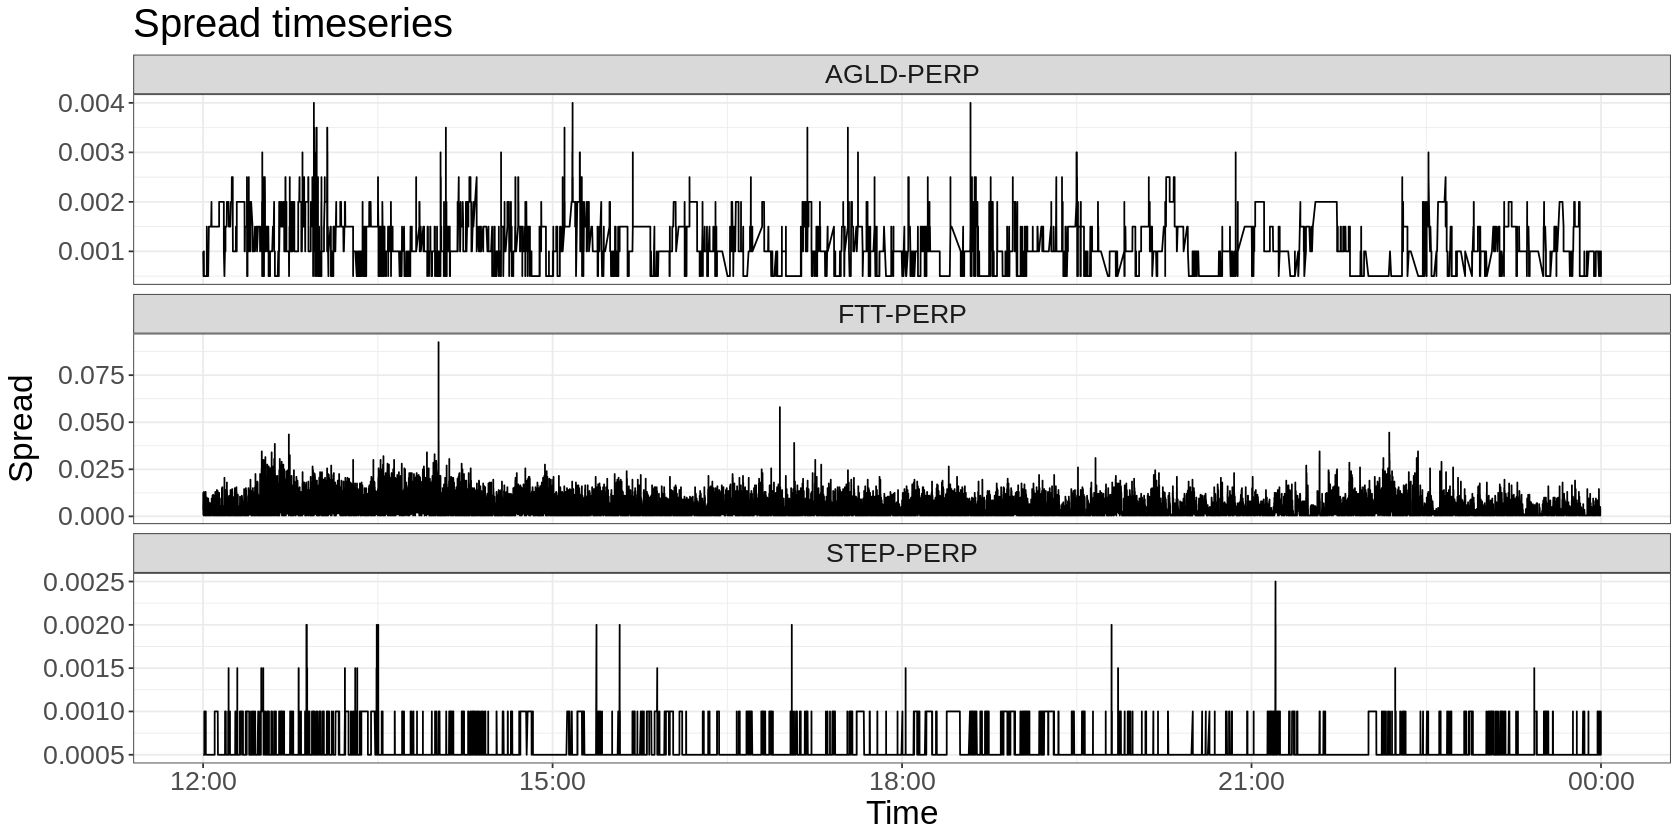

In [6]:
bbo %>% 
  filter(symbol %in% c("AGLD-PERP", "FTT-PERP", "STEP-PERP")) %>% 
  ggplot(aes(x = datetime, y = spread)) +
    geom_line() +
    facet_wrap(~symbol, scales = "free_y", ncol = 1) +
    labs(
      title = "Spread timeseries",
      x = "Time",
      y = "Spread"
    )

It does appear to be a little variable (although we only plot a half day here due to size of data). 

Let's grab some more top-of-book history for a these tickers, one at a time, and plot their mean hourly spread throughout the day:

In [ ]:
# get a longer history for a few tickers
ticker <- 'AGLD-PERP'
start_date <- "2022-05-15"
end_date <- "2022-06-04"
tickers <- c(ticker) 

start_ts <- as.numeric(as.POSIXct(start_date, tz = "UTC"))*1e6
end_ts <- as.numeric(as.POSIXct(end_date, tz = "UTC"))*1e6

longer_bbo <- get_bbo(start_ts, end_ts, tickers)
longer_bbo <- longer_bbo %>% 
  arrange(datetime) %>% 
  mutate(
    spread = ask_price - bid_price,
    spread_pct = 100*spread/(ask_price - (spread/2))
  )

longer_bbo %>% 
  group_by(symbol) %>% 
  summarise(
    count = n(), 
    mean_spread = mean(spread),
    mean_spread_pct = mean(spread_pct)
  ) %>% 
  arrange(mean_spread_pct)

symbol,count,mean_spread,mean_spread_pct
<chr>,<int>,<dbl>,<dbl>
AGLD-PERP,800759,0.001646378,0.2987819


`summarise()` has grouped output by 'symbol'. You can override using the
`.groups` argument.


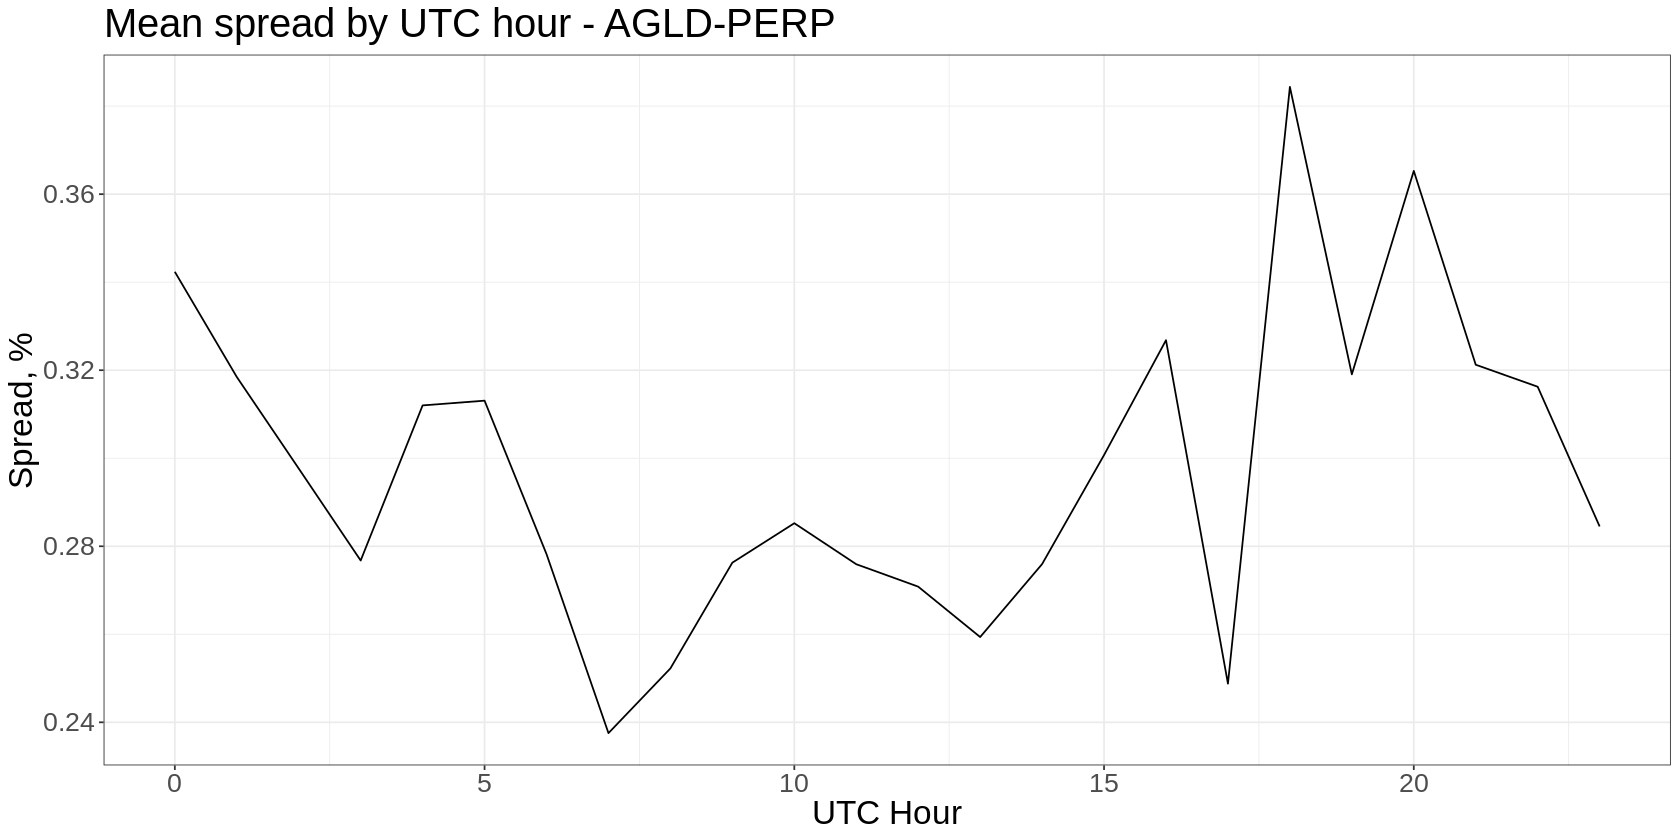

In [ ]:
hourly_spread <- longer_bbo %>% 
  mutate(
    hour = lubridate::hour(datetime),
    minute = lubridate::minute(datetime)
  ) %>% 
  group_by(symbol, hour) %>% 
  summarise(
    spread = mean(spread),
    spread_pct = mean(spread_pct)
  )

hourly_spread %>% 
  ggplot(aes(x = hour, y = spread_pct)) +
    geom_line() +
    labs(
      title = glue("Mean spread by UTC hour - {ticker}"),
      x = "UTC Hour",
      y = "Spread, %"
    )

rm(longer_bbo)

Does this suggest the spread is lower in the earlier part of the UTC day? This perp is pretty illiquid... let's next look at something a bit more liquid:

In [ ]:
# get a longer history for a few tickers
ticker <- 'FTT-PERP'
start_date <- "2022-05-15"
end_date <- "2022-06-04"
tickers <- c(ticker) 

start_ts <- as.numeric(as.POSIXct(start_date, tz = "UTC"))*1e6
end_ts <- as.numeric(as.POSIXct(end_date, tz = "UTC"))*1e6

longer_bbo <- get_bbo(start_ts, end_ts, tickers)
longer_bbo <- longer_bbo %>% 
  arrange(datetime) %>% 
  mutate(
    spread = ask_price - bid_price,
    spread_pct = 100*spread/(ask_price - (spread/2))
  )

longer_bbo %>% 
  group_by(symbol) %>% 
  summarise(
    count = n(), 
    mean_spread = mean(spread),
    mean_spread_pct = mean(spread_pct)
  ) %>% 
  arrange(mean_spread_pct)

symbol,count,mean_spread,mean_spread_pct
<chr>,<int>,<dbl>,<dbl>
FTT-PERP,6020798,0.008161577,0.02751763


`summarise()` has grouped output by 'symbol'. You can override using the
`.groups` argument.


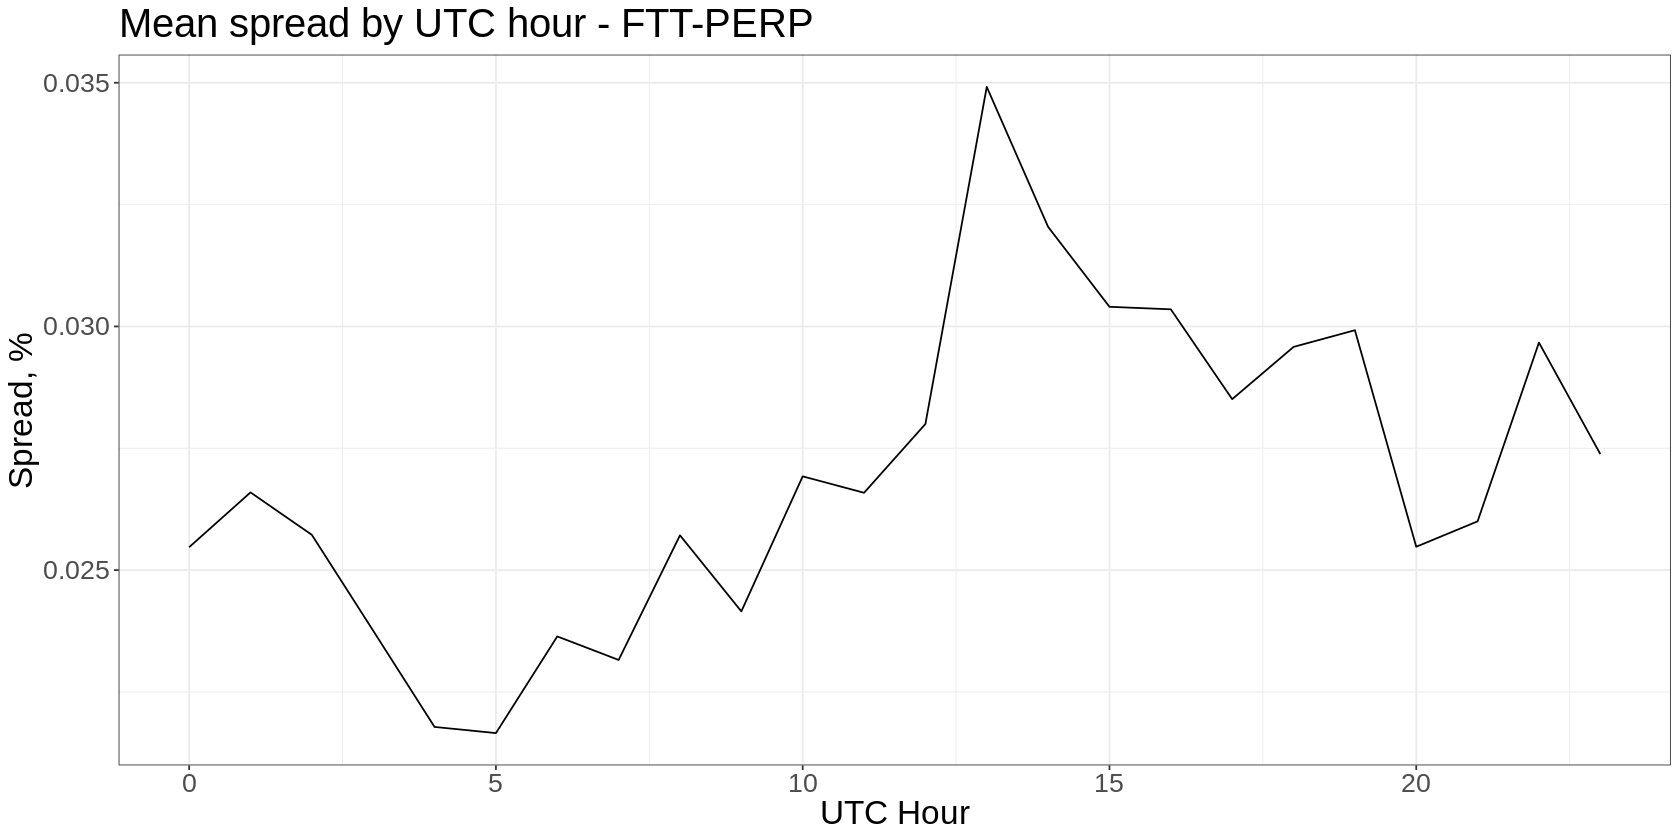

In [ ]:
hourly_spread <- longer_bbo %>% 
  mutate(
    hour = lubridate::hour(datetime),
    minute = lubridate::minute(datetime)
  ) %>% 
  group_by(symbol, hour) %>% 
  summarise(
    spread = mean(spread),
    spread_pct = mean(spread_pct)
  )

hourly_spread %>% 
  ggplot(aes(x = hour, y = spread_pct)) +
    geom_line() +
    labs(
      title = glue("Mean spread by UTC hour - {ticker}"),
      x = "UTC Hour",
      y = "Spread, %"
    )

rm(longer_bbo)

Hmmmm, yes, the spread is clearly lower early in the UTC day. Let's do one more:

In [ ]:
# get a longer history for a few tickers
ticker <- 'STEP-PERP'
start_date <- "2022-05-15"
end_date <- "2022-06-04"
tickers <- c(ticker) 

start_ts <- as.numeric(as.POSIXct(start_date, tz = "UTC"))*1e6
end_ts <- as.numeric(as.POSIXct(end_date, tz = "UTC"))*1e6

longer_bbo <- get_bbo(start_ts, end_ts, tickers)
longer_bbo <- longer_bbo %>% 
  arrange(datetime) %>% 
  mutate(
    spread = ask_price - bid_price,
    spread_pct = 100*spread/(ask_price - (spread/2))
  )

longer_bbo %>% 
  group_by(symbol) %>% 
  summarise(
    count = n(), 
    mean_spread = mean(spread),
    mean_spread_pct = mean(spread_pct)
  ) %>% 
  arrange(mean_spread_pct)

symbol,count,mean_spread,mean_spread_pct
<chr>,<int>,<dbl>,<dbl>
STEP-PERP,1564586,0.0005877472,0.7239939


`summarise()` has grouped output by 'symbol'. You can override using the
`.groups` argument.


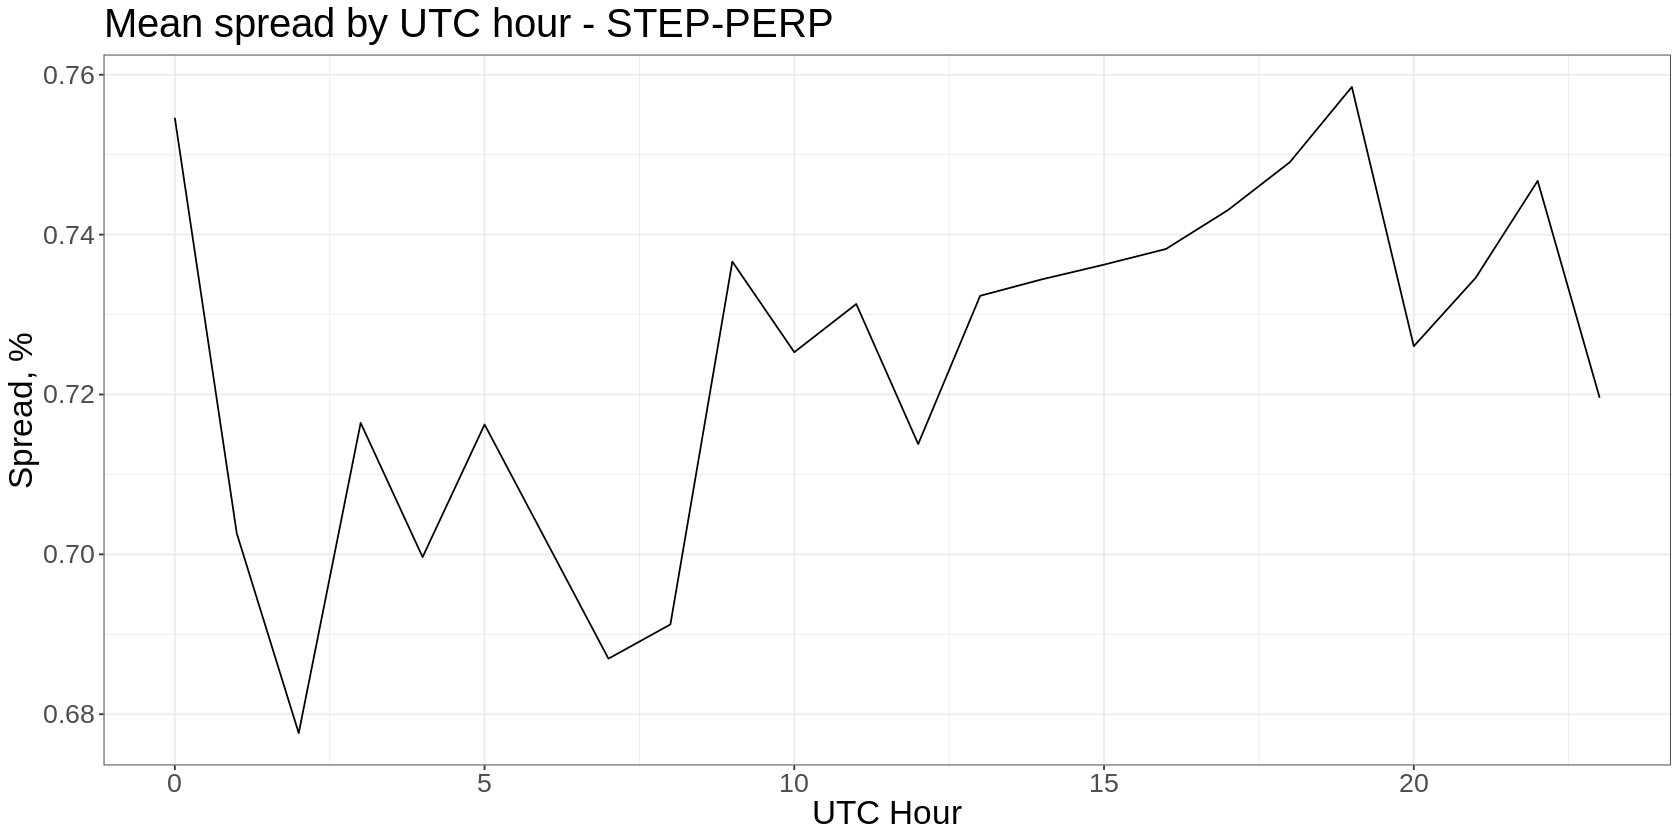

In [ ]:
hourly_spread <- longer_bbo %>% 
  mutate(
    hour = lubridate::hour(datetime),
    minute = lubridate::minute(datetime)
  ) %>% 
  group_by(symbol, hour) %>% 
  summarise(
    spread = mean(spread),
    spread_pct = mean(spread_pct)
  )

hourly_spread %>% 
  ggplot(aes(x = hour, y = spread_pct)) +
    geom_line() +
    labs(
      title = glue("Mean spread by UTC hour - {ticker}"),
      x = "UTC Hour",
      y = "Spread, %"
    )

rm(longer_bbo)

The effect shows up here too. It's quite pronounced in this particular example. 

I think we've seen enough to tentatively conclude that we'll see lower spreads (and cheaper execution of the basis trade) during the UTC morning. 

## Funding Hurdle

Next we want to model a minimum funding hurdle ($H$) in order to make trading a given spread viable. 

$H$ depends on:
- costs ($c$)
- expected accrued funding ($f_{tot}$)

Our total cost is made up of several components. We pay these costs twice (on the way in and on the way out) on both legs of the spread:
- taker commission on the perp ($comm_t$)
- maker commission on the spot ($comm_m$)
- spread on the perp and on the spot ($s$)

Expected accrued funding ($f_{tot}$) is dependent on:
- the expected funding rate ($f$)
- the time the position is held ($t$)

In the previous work, we found that the funding rate tended to noisily revert over about 7 days. We also found that the mean 4-day funding rate tended to be a reasonable, noisy predictor of the next 7-day's accrued funding. 

Tthe accrued funding based on this expected funding rate would be:

$f_{tot} = f*t/365$

where $f$ is in percent per annum.

If we set our funding rate $f$ to $H$ (in %pa) we get:

$f_{tot} = H*t/365$  

And costs as a percent of total position size (perp and spot) are:
$c = 2((comm_t + comm_m)/2 + s)$  

(our total commission cost on one way of the entire position is the mean of the taker and maker commissions plus the mean of the perp and spot spreads, which we assume are the same. round trip cost is this times 2).

Set $f_{tot} = c$ for the break-even point, and rearrange to solve for $H$:

In [31]:
h_min <- function(hold_time, taker_comm, maker_comm, spread) {
  2*365*((taker_comm + maker_comm)/2 + spread)/hold_time
}

We'll use the tier 1 fee structure for FTX for our maker and taker commissions:
- maker commission: 0.02%
- taker commission: 0.07%



Let's explore how our minimum funding rate varies with spread and hold time. 

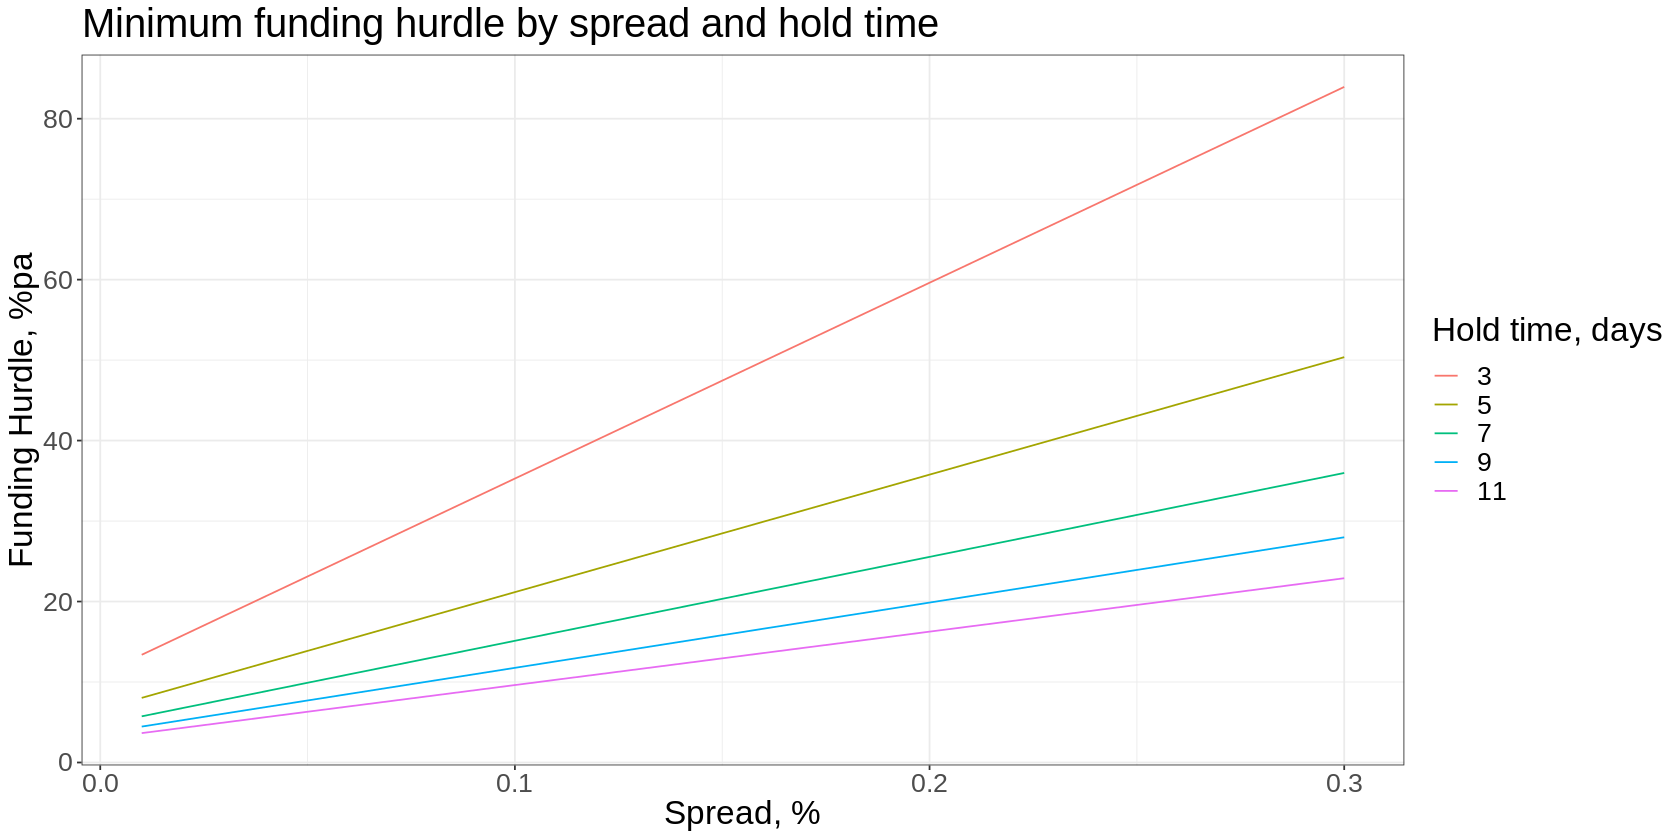

In [32]:
spreads <- seq(0.01, 0.3, 0.01)/100  # based on average spread by ticker above
hold_times <- seq(3, 11, 2)
taker_comm <- 0.07/100
maker_comm <- 0.02/100

min_hurdle <- expand.grid(spreads, hold_times)
colnames(min_hurdle) <- c("spread", "hold_time")

min_hurdle <- min_hurdle %>% 
  mutate(hurdle = map2_dbl(.x = hold_time, .y = spread, .f = h_min, taker_comm = taker_comm, maker_comm = maker_comm))

min_hurdle %>% 
  ggplot(aes(x = spread*100, y = hurdle*100, colour = factor(hold_time))) +
  geom_line() +
  labs(
    title = "Minimum funding hurdle by spread and hold time",
    x = "Spread, %",
    y = "Funding Hurdle, %pa",
    colour = "Hold time, days"
  )

We can see that hold time has a strong impact on the minimum viable funding hurdle.

Based on our experience, a hold time of 5-9 days is generally a reasonable expectation. In previous work, we set the hold time to 7 days. 

The lower our spread costs, the lower our minimum funding hurdle. 

(recall that in our model, the minimum funding hurdle is the predicted accrued funding, estimated by 7x the mean 4-day funding rate).

But lowering our maximum spread is in turn is going to reduce our tradable universe.

At this point we turn to simulation to explore these trade offs. 



### Get FTX perpetual funding history

In [7]:
rwRtools:::transfer_lab_object(
      pod = "Crypto",
      object = "ftx_perpetual_funding_rates.feather",
      path = "."
)

funding <- feather::read_feather('ftx_perpetual_funding_rates.feather')
funding <- funding %>% mutate(date = lubridate::as_datetime(date))
tail(funding)

ℹ Downloading ftx_perpetual_funding_rates.feather

✔ Saved ftx_perpetual_funding_rates.feather to ./ftx_perpetual_funding_rates.fe…





File successfully transferred


[1] TRUE

ticker,date,rate
<chr>,<dttm>,<dbl>
ZRX-PERP,2022-05-31 02:00:00,4.0e-06
ZRX-PERP,2022-05-31 03:00:00,-1.9e-05
ZRX-PERP,2022-05-31 04:00:00,-5.0e-06
ZRX-PERP,2022-05-31 05:00:00,-1.0e-05
ZRX-PERP,2022-05-31 06:00:00,-1.4e-05
ZRX-PERP,2022-05-31 07:00:00,1.3e-05


Plot some funding rate time series

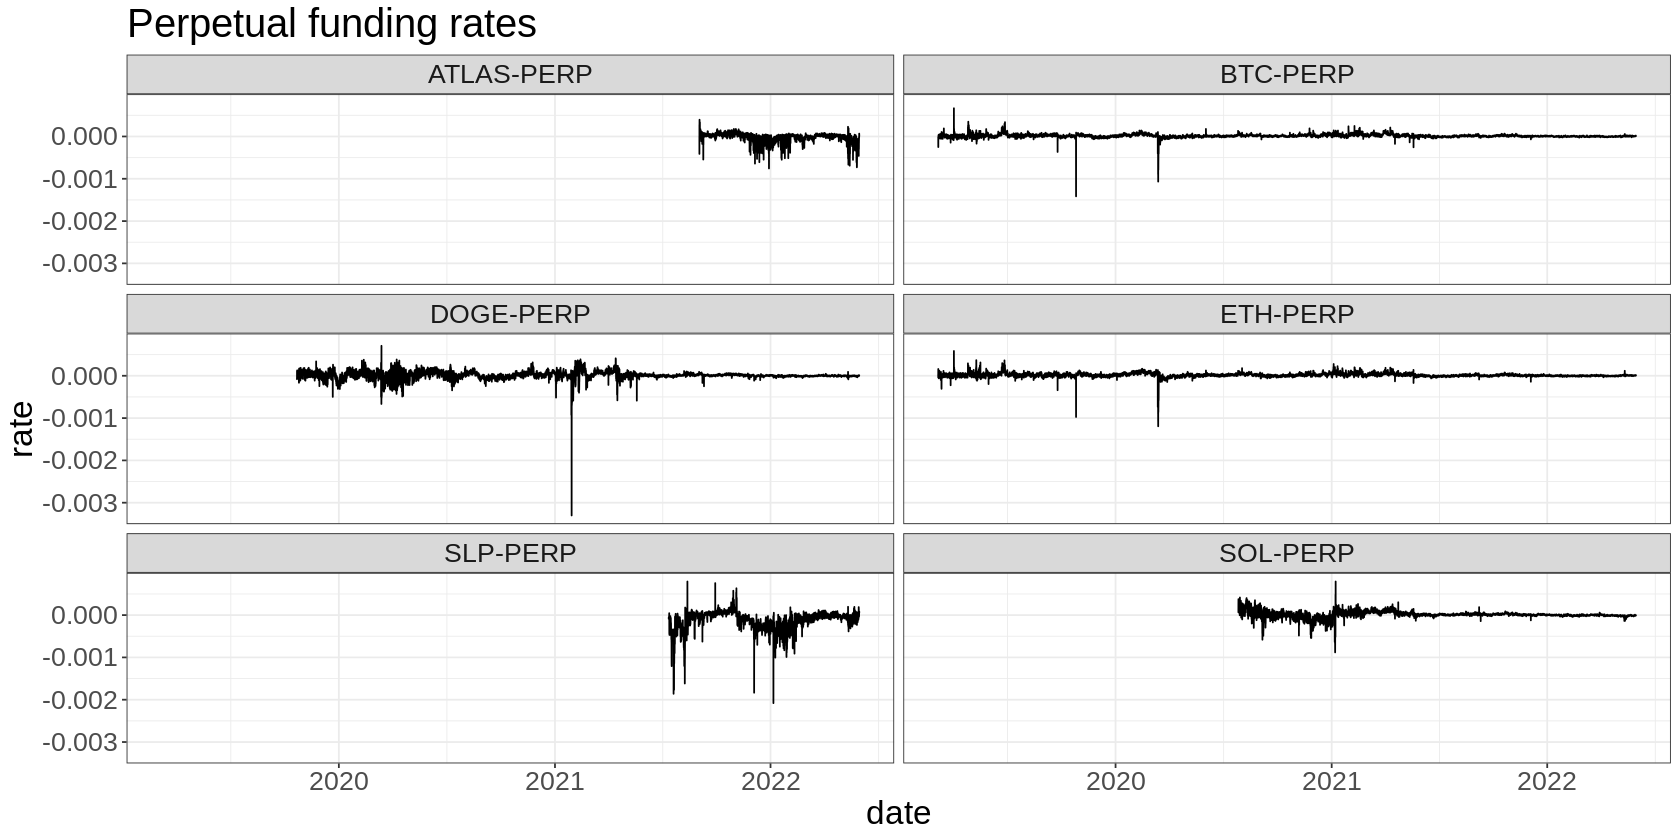

In [8]:
funding %>%
  filter(ticker %in% c("BTC-PERP", "ETH-PERP", "SOL-PERP", "DOGE-PERP", "SLP-PERP", "ATLAS-PERP")) %>%
  group_by(ticker) %>%
  ggplot(aes(x = date, y = rate)) +
    geom_line() +
    facet_wrap(~ticker, ncol = 2) +
    labs(title = "Perpetual funding rates")

Create funding model from mean four-day funding rate:

In [9]:
daily_funding <- funding %>% 
  mutate(day = date(date), hour = hour(date)) %>% 
  group_by(ticker, day) %>% 
  summarise(rate = sum(rate, na.rm = TRUE))

# create funding model 
funding_model <- daily_funding %>%
  group_by(ticker) %>%
  mutate(
    # predicted funding is 7x mean funding over last 4 days
    predicted_funding = 7*(rate + dplyr::lag(rate, 1) + dplyr::lag(rate, 2) + dplyr::lag(rate, 3))/4,
    # actual funding is the sum of funding over the forward 7 days
    actual_funding = dplyr::lead(rate, 1) + dplyr::lead(rate, 2) + dplyr::lead(rate, 3) + dplyr::lead(rate, 4) + dplyr::lead(rate, 5) + dplyr::lead(rate, 6) + dplyr::lead(rate, 7)
  ) 

head(funding_model)

`summarise()` has grouped output by 'ticker'. You can override using the
`.groups` argument.


ticker,day,rate,predicted_funding,actual_funding
<chr>,<date>,<dbl>,<dbl>,<dbl>
1INCH-PERP,2020-12-25,0.000434,NA,0.008082
1INCH-PERP,2020-12-26,-0.002614,NA,0.010646
1INCH-PERP,2020-12-27,0.002228,NA,0.010133
1INCH-PERP,2020-12-28,0.003072,0.005460,0.009330
1INCH-PERP,2020-12-29,0.002202,0.008554,0.009117
1INCH-PERP,2020-12-30,0.001630,0.015981,0.009389


Here's a plot of predicted funding vs actual funding:

`geom_smooth()` using formula 'y ~ x'



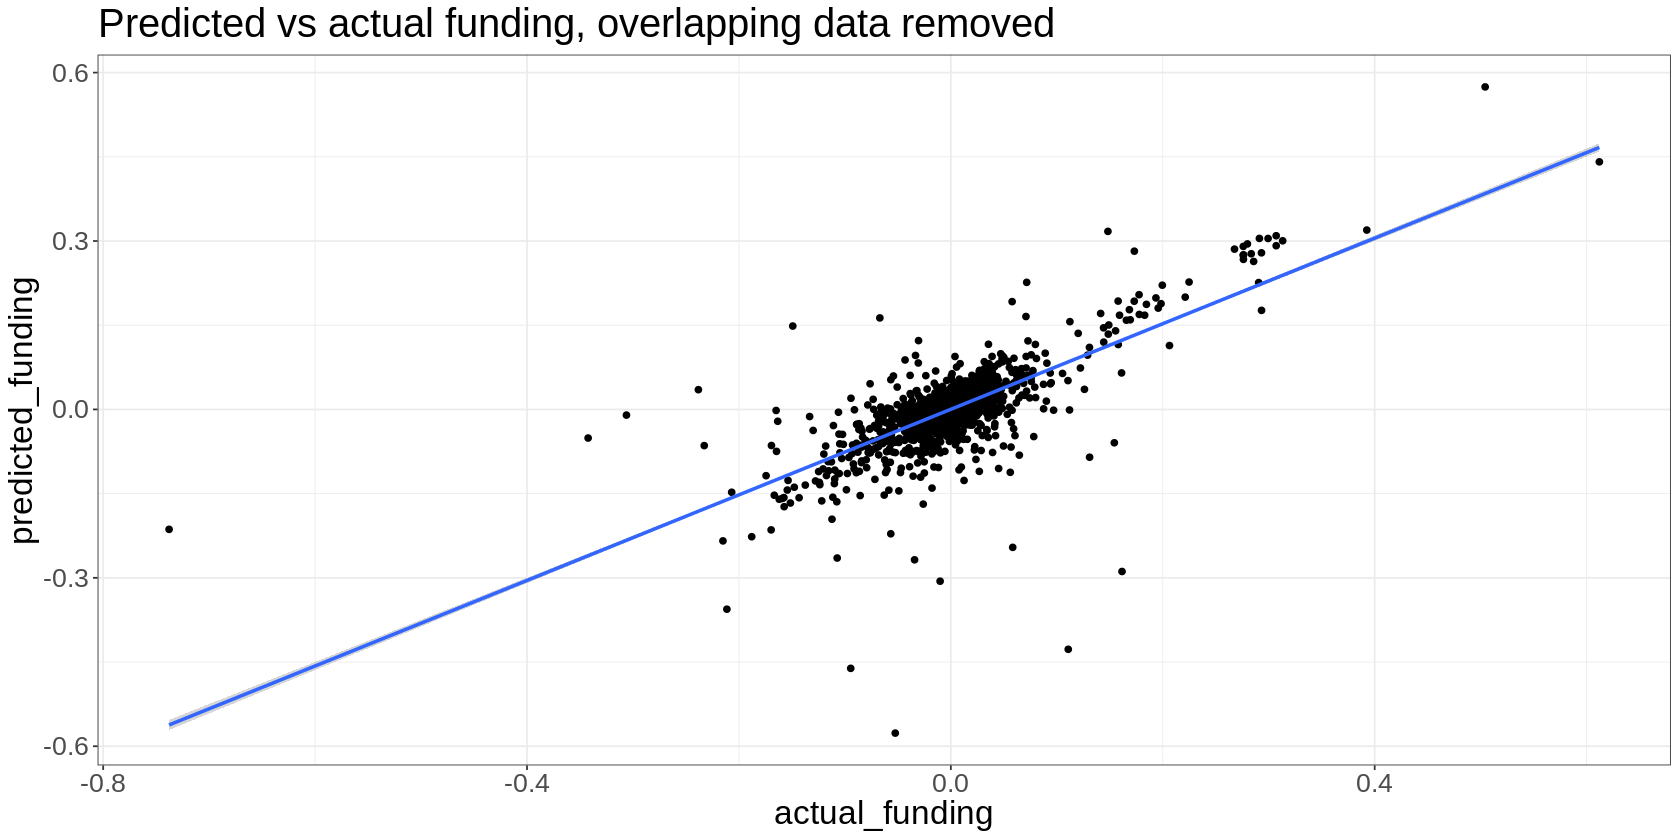

In [ ]:
funding_model %>%
  group_by(ticker) %>%
  filter(row_number() %% 7 == 0) %>%
  na.omit() %>%
  ggplot(aes(x = actual_funding, y = predicted_funding)) +
    geom_point() +
    geom_smooth(method = "lm") +
    labs(title = "Predicted vs actual funding, overlapping data removed")

Let's simulate a simple trading strategy based on the model:
- create universe with a maximum average spread, x
- rotate between the n perpetuals with the highest forecast basis, over a minimum hurdle, y

First, get some perpetual price data:

In [10]:
rwRtools:::transfer_lab_object(
      pod = "Crypto",
      object = "ftx_futures_ohlc_1h.feather",
      path = "."
)

futs <- feather::read_feather('ftx_futures_ohlc_1h.feather')
futs <- futs %>% mutate(date = lubridate::as_datetime(date)) %>%
  filter(str_detect(ticker, "-PERP"))

tail(futs)

ℹ Downloading ftx_futures_ohlc_1h.feather

✔ Saved ftx_futures_ohlc_1h.feather to ./ftx_futures_ohlc_1h.feather  ( 193 Mb )





File successfully transferred


[1] TRUE

ticker,date,open,high,low,close,volume
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ZRX-PERP,2022-05-31 03:00:00,0.43125,0.43625,0.42600,0.43050,175705.47
ZRX-PERP,2022-05-31 04:00:00,0.43050,0.43275,0.42725,0.42975,150764.32
ZRX-PERP,2022-05-31 05:00:00,0.42975,0.43000,0.42025,0.42050,211345.15
ZRX-PERP,2022-05-31 06:00:00,0.42050,0.42100,0.41375,0.41675,287872.30
ZRX-PERP,2022-05-31 07:00:00,0.41675,0.42050,0.41550,0.42025,117085.14
ZRX-PERP,2022-05-31 08:00:00,0.42025,0.42075,0.42000,0.42075,12960.93


In [11]:
# make daily OHLCV (UTC midnight - UTC midnight)
daily_futs <- futs %>%
  separate(date, into = c("date", "time"), sep = " ") %>%
  group_by(ticker, date) %>%
  summarise(
    open = first(open),
    high = max(high),
    low = min(low),
    close = last(close),
    volume = sum(volume)
  ) %>%
  mutate(date = as_date(date))

tail(daily_futs)

`summarise()` has grouped output by 'ticker'. You can override using the
`.groups` argument.


ticker,date,open,high,low,close,volume
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ZRX-PERP,2022-05-26,0.41900,0.42500,0.36600,0.38625,4546098
ZRX-PERP,2022-05-27,0.38625,0.39075,0.35725,0.36775,4228116
ZRX-PERP,2022-05-28,0.36775,0.38750,0.36025,0.37875,3055150
ZRX-PERP,2022-05-29,0.37875,0.39050,0.37050,0.39000,2819519
ZRX-PERP,2022-05-30,0.39000,0.42900,0.38500,0.42850,2628232
ZRX-PERP,2022-05-31,0.42850,0.43625,0.41375,0.42075,1571125


Check looks sensible

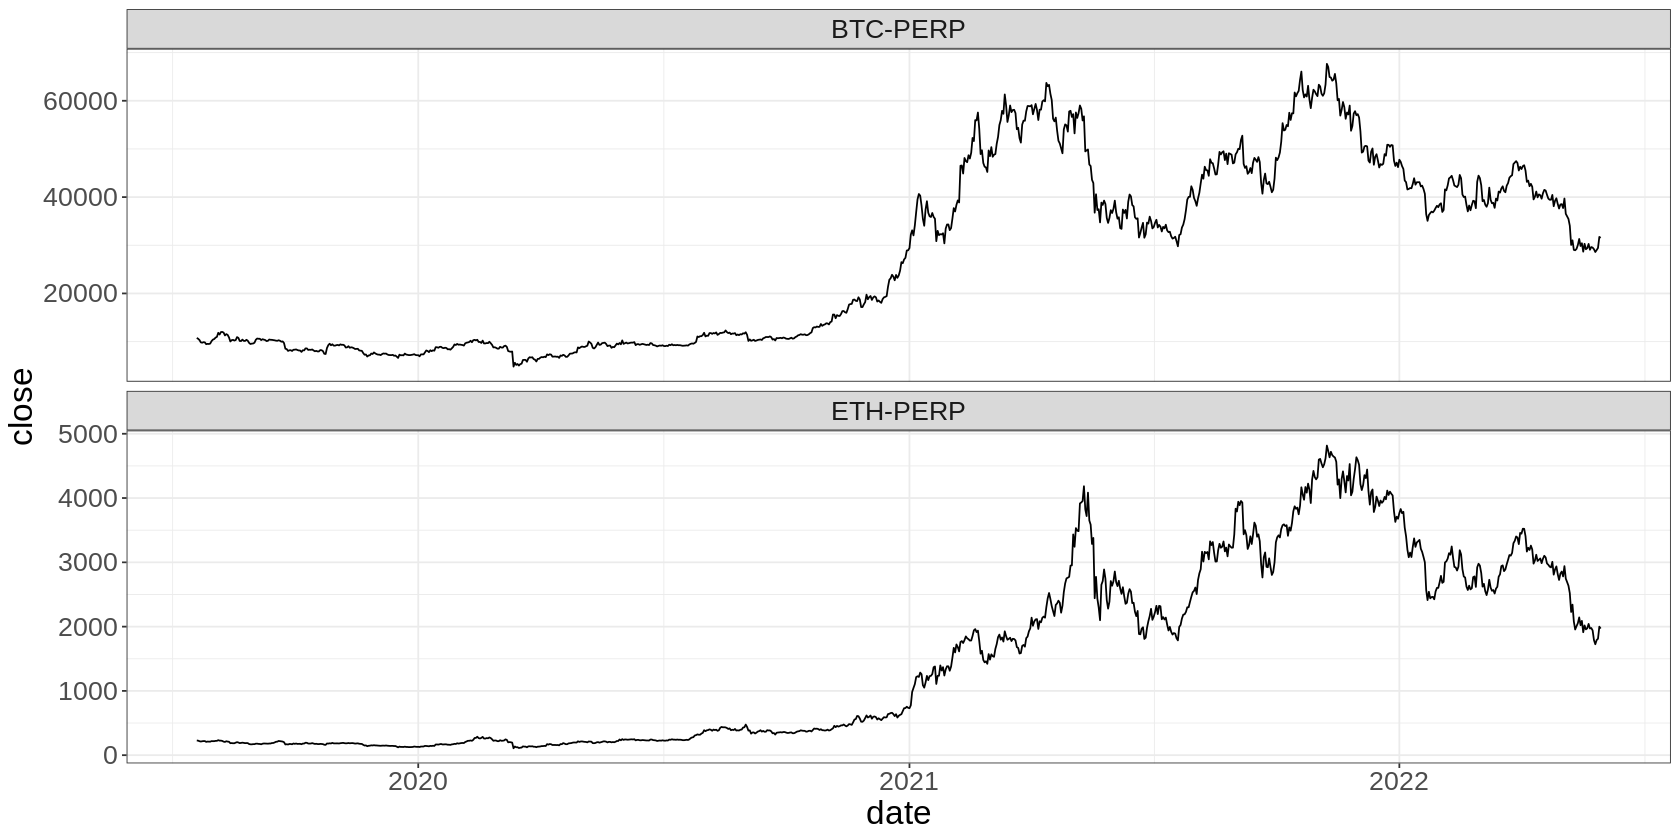

In [12]:
daily_futs %>%
  filter(ticker %in% c("BTC-PERP", "ETH-PERP")) %>%
  ggplot(aes(x = date, y = close)) +
    geom_line() +
    facet_wrap(~ticker, ncol = 1, scales = "free_y") 

Get spot data

In [13]:
rwRtools:::transfer_lab_object(
      pod = "Crypto",
      object = "ftx_spot_ohlc_1h.feather",
      path = "."
)

spot <- feather::read_feather('ftx_spot_ohlc_1h.feather')
spot <- spot %>% mutate(date = lubridate::as_datetime(date)) 
tail(spot) 

ℹ Downloading ftx_spot_ohlc_1h.feather

✔ Saved ftx_spot_ohlc_1h.feather to ./ftx_spot_ohlc_1h.feather  ( 614.8 Mb )





File successfully transferred


[1] TRUE

ticker,date,open,high,low,close,volume
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ZRX/USD,2022-05-31 04:00:00,0.43050,0.43250,0.42800,0.42950,78.72725
ZRX/USD,2022-05-31 05:00:00,0.42950,0.42950,0.42100,0.42100,9439.00625
ZRX/USD,2022-05-31 06:00:00,0.42100,0.42125,0.41475,0.41675,638.14075
ZRX/USD,2022-05-31 07:00:00,0.41675,0.42025,0.41625,0.42025,2758.59550
ZRX/USD,2022-05-31 08:00:00,0.42025,0.42225,0.41975,0.42125,32.49800
ZRX/USD,2022-05-31 09:00:00,0.42125,0.42125,0.42075,0.42075,0.42075


In [14]:
# wrangle into daily 
daily_spot <- spot %>%
  separate(date, into = c("date", "time"), sep = " ") %>%
  group_by(ticker, date) %>%
  summarise(
    open = first(open),
    high = max(high),
    low = min(low),
    close = last(close),
    volume = sum(volume)
  ) %>%
  mutate(date = as_date(date))
  
tail(daily_spot)

`summarise()` has grouped output by 'ticker'. You can override using the
`.groups` argument.


ticker,date,open,high,low,close,volume
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ZRX/USD,2022-05-26,0.41850,0.42450,0.36650,0.38625,56293.86
ZRX/USD,2022-05-27,0.38625,0.39025,0.35775,0.36725,36303.14
ZRX/USD,2022-05-28,0.36725,0.38700,0.36125,0.37950,35864.37
ZRX/USD,2022-05-29,0.37950,0.39025,0.37125,0.38925,32948.24
ZRX/USD,2022-05-30,0.38925,0.42800,0.38600,0.42800,20126.85
ZRX/USD,2022-05-31,0.42800,0.43550,0.41475,0.42075,26477.40


Check data looks sensible

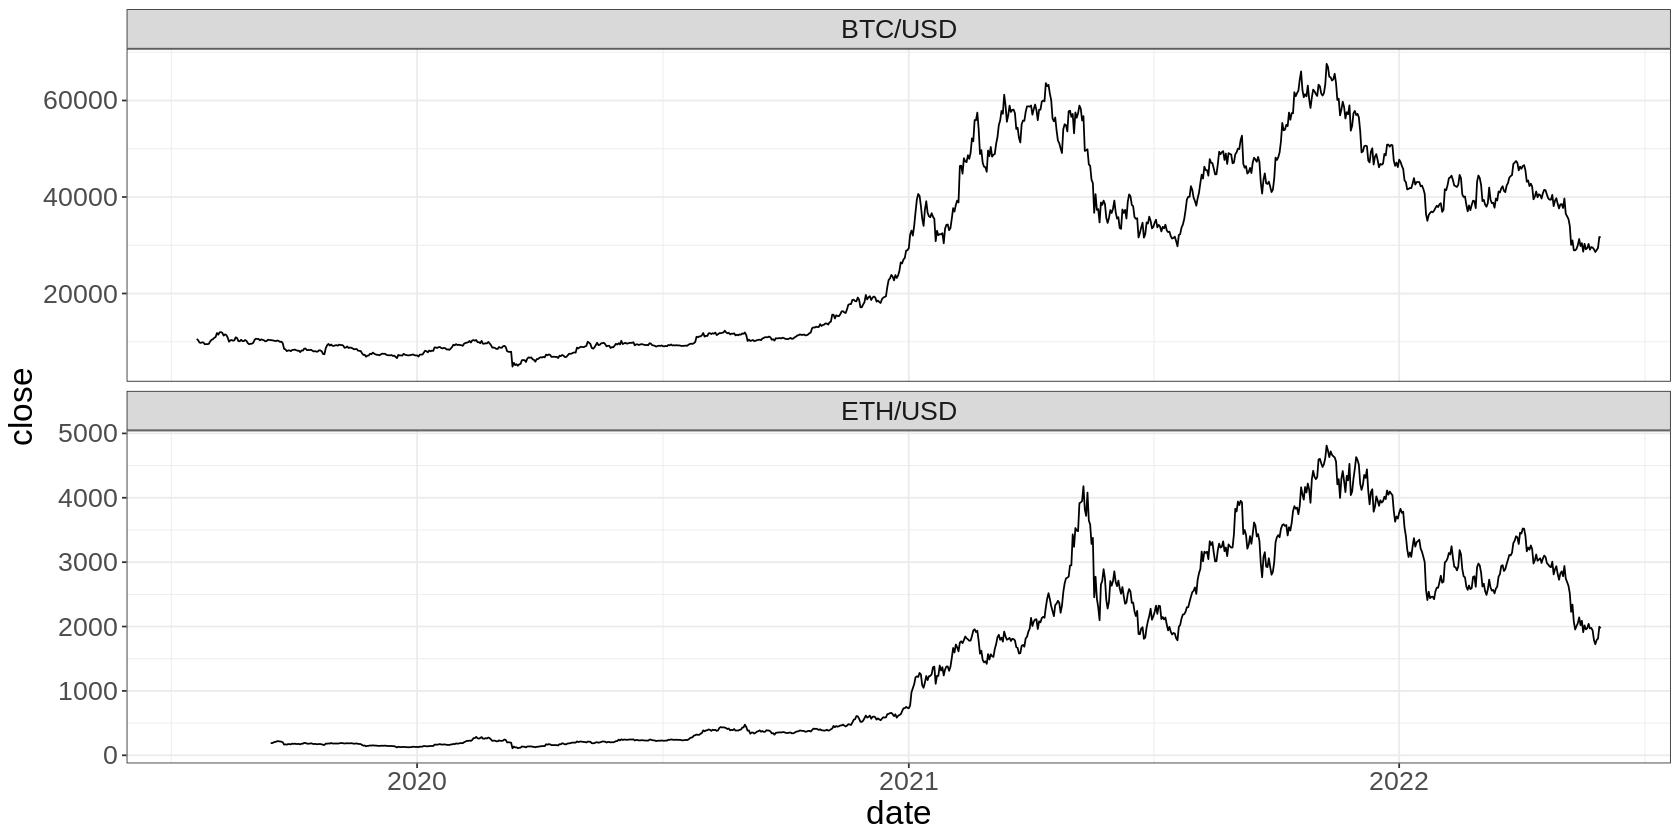

In [15]:
daily_spot %>%
  filter(ticker %in% c("BTC/USD", "ETH/USD")) %>%
  ggplot(aes(x = date, y = close)) +
    geom_line() +
    facet_wrap(~ticker, ncol = 1, scales = "free_y") 

Make universe data set from stuff where:
- We have perp and spot daily closes
- average spread in the perp is above some cutoff

Also ditch AMPL as it does some funky rebase stuff that we can't really account for in our model. 

In [16]:
mean_spread_pct <- bbo %>% 
  group_by(symbol) %>% 
  summarise(
    count = n(), 
    mean_spread = mean(spread),
    mean_spread_pct = mean(spread_pct)
  ) %>% 
  arrange(mean_spread_pct)

head(mean_spread_pct)

symbol,count,mean_spread,mean_spread_pct
<chr>,<int>,<dbl>,<dbl>
GMT-PERP,511174,1.399529e-04,0.01390840
DOGE-PERP,165994,1.649255e-05,0.02055287
FTT-PERP,135228,5.906003e-03,0.02274533
LTC-PERP,124396,1.634900e-02,0.02633951
AVAX-PERP,226700,6.453449e-03,0.02823731
DOT-PERP,140770,2.956738e-03,0.03170879


In [17]:
# get viable symbols

cutoff = 0.05  # maximum average % spread

symbols <- mean_spread_pct %>%
  filter(mean_spread_pct <= cutoff) %>%
  pull(symbol)

# add back in unprocessed symbols that will be tradable
# RUNE-PERP average spread ~0.048%
# TOMO-PERP ~0.17%
# BCH-PERP ~0.04%
symbols <- c(symbols, c('BTC-PERP', 'ETH-PERP', 'ATOM-PERP', 'LINK-PERP', 'MATIC-PERP', 'SOL-PERP', 'SUSHI-PERP', 'RUNE-PERP', 'BCH-PERP', 'TRX-PERP'))

In [18]:
symbols

[1] "GMT-PERP"   "DOGE-PERP"  "FTT-PERP"   "LTC-PERP"   "AVAX-PERP" 
 [6] "DOT-PERP"   "NEAR-PERP"  "FTM-PERP"   "KNC-PERP"   "MANA-PERP" 
[11] "SAND-PERP"  "AXS-PERP"   "HT-PERP"    "GALA-PERP"  "BTC-PERP"  
[16] "ETH-PERP"   "ATOM-PERP"  "LINK-PERP"  "MATIC-PERP" "SOL-PERP"  
[21] "SUSHI-PERP" "RUNE-PERP"  "BCH-PERP"   "TRX-PERP"

In [21]:
universe_df <- daily_futs %>%
  select(ticker, date, close, volume) %>%
  rename("close_perp" = close, "volume_perp" = volume) %>%
  # join spot
    # first drop "-PERP" from ticker
  mutate(ticker = str_remove(ticker, "-PERP")) %>%
  left_join(
    daily_spot %>% 
      # likewise drop "/USD" from ticker
      mutate(ticker = str_remove(ticker, "/USD")) %>%
      select(ticker, date, close) %>%
      rename("close_spot" = close),
    by = c("date", "ticker")
  ) %>%
  # ditch rows where we don't have both perp and spot closing prices
  na.omit() %>%
  # ditch AMPL
  filter(ticker != "AMPL") %>%
  arrange(date) %>%
  # flag if something is in universe
  mutate(is_universe = case_when(ticker %in% str_remove(symbols, "-PERP") ~ 1, TRUE ~ 0))

tail(universe_df)

ticker,date,close_perp,volume_perp,close_spot,is_universe
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
WAVES,2022-05-31,8.32800,229829931.9,8.432500,0
XAUT,2022-05-31,1858.40000,194116.9,1848.500000,0
XRP,2022-05-31,0.41795,32217716.4,0.420675,0
YFI,2022-05-31,8150.00000,3646763.2,8175.000000,0
YFII,2022-05-31,540.50000,805241.5,542.750000,0
ZRX,2022-05-31,0.42075,1571125.3,0.420750,0


Check how many perpetuals are in our universe given these criteria:

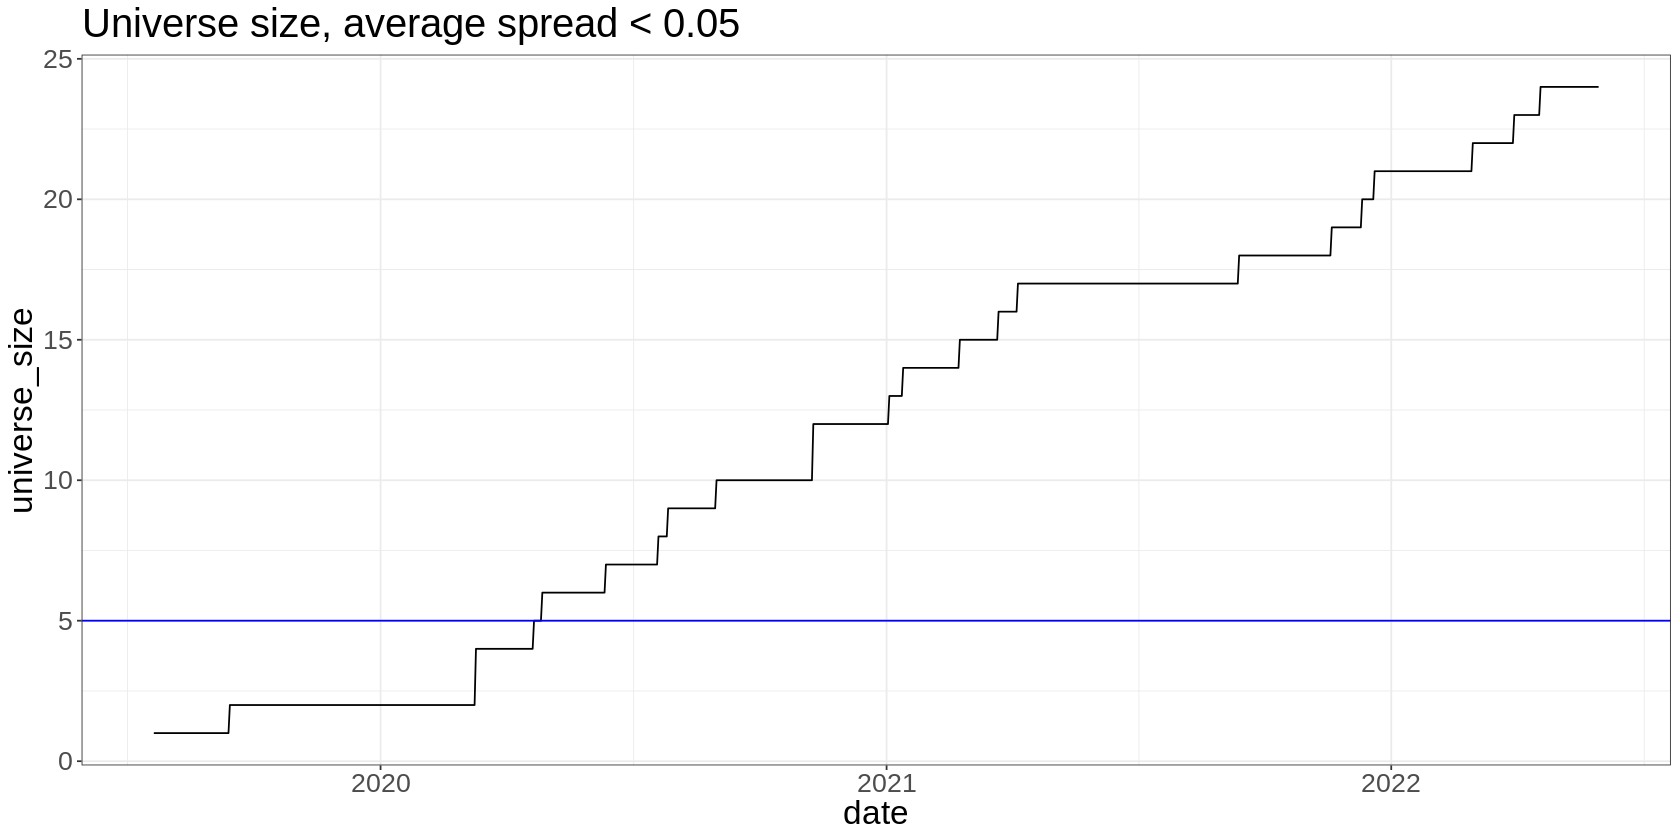

In [22]:
# how many in our universe?
universe_cutoff <- 5

universe_df %>%
  group_by(date) %>%
  summarise(universe_size = sum(is_universe)) %>%
  ggplot(aes(x = date, y = universe_size)) +
    geom_line() +
    geom_hline(yintercept = universe_cutoff, colour = "blue") +
    labs(title = glue("Universe size, average spread < {cutoff}"))

We have n or more coins in our universe from early 2020 onwards. We'll filter our data set prior to that date:

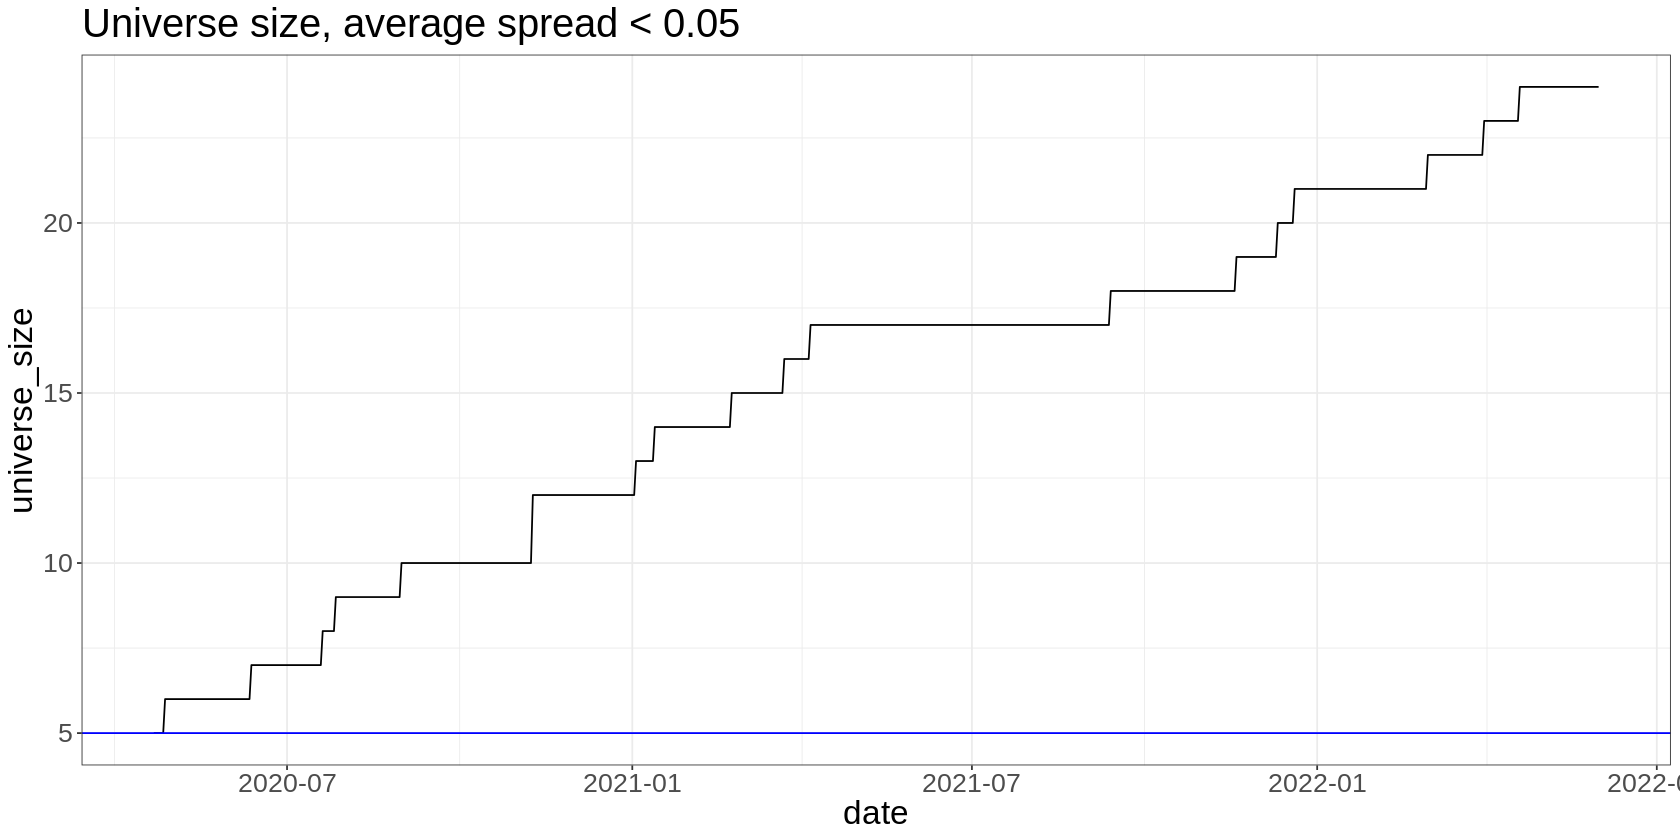

In [23]:
cutoff_date <- universe_df %>%
  group_by(date) %>%
  summarise(universe_size = sum(is_universe)) %>%
  filter(universe_size >= universe_cutoff) %>%
  summarise(cutoff_date = first(date)) %>%
  pull(cutoff_date)

universe_df <- universe_df %>%
  filter(date >= cutoff_date)

universe_df %>%
  group_by(date) %>%
  summarise(universe_size = sum(is_universe)) %>%
  ggplot(aes(x = date, y = universe_size)) +
    geom_line() +
    geom_hline(yintercept = universe_cutoff, colour = "blue") +
    labs(title = glue("Universe size, average spread < {cutoff}"))

Next we'll create a backtest df by joining the daily funding rate to our universe df and calculating positions from our funding model. 

The timestamp in the funding df represents when funding is paid. eg if the timesteamp is 2:00:00, it represents the funding accrued for the period 1:00:00-1:59:59 and paid on 2:00:00.

So to align funding rate with the hour in which it is accrued, we nead to *lead* the hourly funding rate. This is what we should use in our model of future funding.

Remake daily funding df accordingly. In this df, `rate` is the funding accrued on that day. (In reality it's accrued throughout the day - but we'll essentially summarise the dynamics to a daily resolution).

In [24]:
daily_funding <- funding %>% 
  mutate(hour = hour(date), date = date(date)) %>% 
  # group by ticker and lead hourly funding rate
  group_by(ticker) %>%
  mutate(rate = dplyr::lead(rate)) %>%
  # group by ticker and day and sum to get daily funding
  group_by(ticker, date) %>% 
  summarise(rate = sum(rate, na.rm = TRUE))

tail(daily_funding)

`summarise()` has grouped output by 'ticker'. You can override using the
`.groups` argument.


ticker,date,rate
<chr>,<date>,<dbl>
ZRX-PERP,2022-05-26,-0.000692
ZRX-PERP,2022-05-27,-0.000739
ZRX-PERP,2022-05-28,-0.000929
ZRX-PERP,2022-05-29,-0.000819
ZRX-PERP,2022-05-30,-0.000376
ZRX-PERP,2022-05-31,-0.000033


Model of predicted funding:

Originally we used the mean four-day funding rate. But we get essentially the same result if we use the three-day funding rate instead, and this is conveniently available at [ftxpremiums.com](https://ftxpremiums.com)

In [25]:
daily_funding <- daily_funding %>%
  group_by(ticker) %>%
  mutate(
    # predicted funding is 7x mean funding over last 4 days
    # predicted_funding = 7*(rate + dplyr::lag(rate, 1) + dplyr::lag(rate, 2) + dplyr::lag(rate, 3))/4
    # try using 3 days as super convenient given ftxpremiums.com
    predicted_funding = 7*(rate + dplyr::lag(rate, 1) + dplyr::lag(rate, 2))/3
  ) 

tail(daily_funding)

ticker,date,rate,predicted_funding
<chr>,<date>,<dbl>,<dbl>
ZRX-PERP,2022-05-26,-0.000692,-0.004781000
ZRX-PERP,2022-05-27,-0.000739,-0.004559333
ZRX-PERP,2022-05-28,-0.000929,-0.005506667
ZRX-PERP,2022-05-29,-0.000819,-0.005803000
ZRX-PERP,2022-05-30,-0.000376,-0.004956000
ZRX-PERP,2022-05-31,-0.000033,-0.002865333


Create a backtest df containing everything we need to do a rough simulation of our basis strategy:
- daily perpetual futures returns
- daily spot returns
- daily accrued perpetual funding rates
- model predicted funding rate
- is_universe flag

In [26]:
backtest_df <- universe_df %>%
  left_join(daily_funding %>% mutate(ticker = str_remove(ticker, "-PERP")), by = c("date", "ticker")) %>%
  # calculate spot return, perp return, and funding return
  arrange(date) %>%
  group_by(ticker) %>%
  mutate(
    return_perp = (close_perp - dplyr::lag(close_perp))/dplyr::lag(close_perp),
    return_spot = (close_spot - dplyr::lag(close_spot))/dplyr::lag(close_spot),
    fwd_return_perp = dplyr::lead(return_perp),
    fwd_return_spot = dplyr::lead(return_spot),
    fwd_funding = dplyr::lead(rate, 2)
  ) %>%
  na.omit()

head(backtest_df)

ticker,date,close_perp,volume_perp,close_spot,is_universe,rate,predicted_funding,return_perp,return_spot,fwd_return_perp,fwd_return_spot,fwd_funding
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ASD,2020-04-22,0.04115,51024.76,0.04082,0,0.004007,0.012443667,0.04150848,0.04106095,0.01433779,0.01004410,0.003909
BCH,2020-04-22,233.35000,5353143.80,233.40000,1,-0.000127,-0.001110667,0.06116417,0.06115026,0.01907007,0.01853042,0.000571
BNB,2020-04-22,15.68500,2117838.23,15.67700,0,-0.000683,-0.012882333,0.03856977,0.03560576,0.02438636,0.02353767,0.000174
BTC,2020-04-22,7134.00000,248485493.14,7135.50000,1,-0.000579,-0.004762333,0.04229673,0.04129880,0.05039249,0.04940088,0.000209
ETH,2020-04-22,183.05000,65237950.12,183.01000,1,-0.000412,-0.002146667,0.07096887,0.07017134,0.01464081,0.01393366,0.000264
LINK,2020-04-22,3.68050,8125276.12,3.67650,1,-0.001511,-0.009289000,0.06434355,0.06180505,0.02200788,0.02284782,0.000878


Next we take positions in the top n by predicted funding, over some threshold. 

In this simulation, we'll sometimes have less than n positions since we won't always have n perps with a high enough funding rate - especially early in the simulation. 

Regardless of the number of positions, we'll assume an equal dollar weight across them all. 

In [27]:
threshold_ann <- 0.3  # annualised funding threshold
model_threshold <- 7*threshold_ann/(365)  # next 7-day's funding threshold
model_threshold

top_n <- universe_cutoff

positions_df <- backtest_df %>%
  filter(is_universe == TRUE) %>%
  # get rid of anything whose predicted funding rate falls under the threshold
  filter(predicted_funding > model_threshold) %>%
  group_by(date) %>%
  # rank by predicted funding rate
  mutate(rank = row_number(desc(predicted_funding))) %>%
  mutate(pos = case_when(rank <= universe_cutoff ~ 1, TRUE ~ 0)) %>%
  select(ticker, date, pos)

tail(positions_df)

[1] 0.005753425

ticker,date,pos
<chr>,<date>,<dbl>
TRX,2021-11-10,0
MANA,2021-11-11,1
RUNE,2021-11-11,1
SAND,2021-11-11,1
SAND,2021-11-12,1
GALA,2021-11-23,1


The funding rate is set a bit higher than what was suggested by the analysis above. 

This is because the simulation isn't really an accurate reflection of how you'd trade this thing. It really needs some sort of mechanism that prefers existing positions over new ones - perhaps something to implement at a later date?

For now, setting a higher threshold funding rate has a similar effect. 

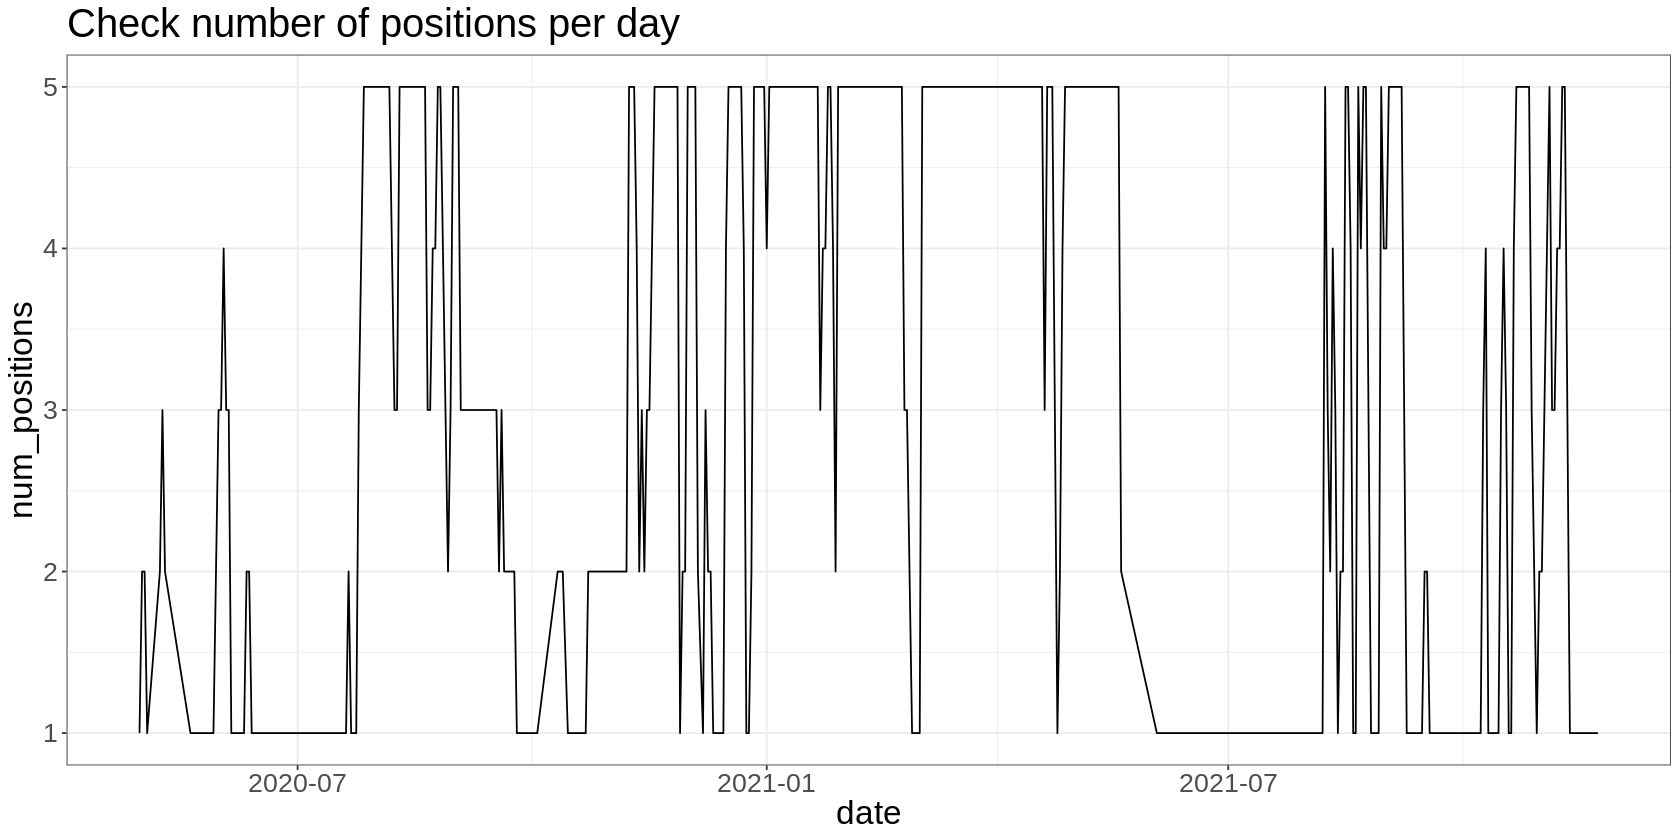

In [28]:
positions_df %>%
  group_by(date) %>%
  summarise(num_positions = sum(pos)) %>%
  ggplot(aes(x = date, y = num_positions)) +
    geom_line() +
    labs(title = "Check number of positions per day")

Next, we'll estimate costs in basis points.

Two options:
- assume we always pay the cutoff spread. This is going to be super conservative 
- assume we always pay the mean of the average spread of all the tickers in our universe. Probably more realistic. 

Assume the latter.

In [29]:
spread_cost_pct <- bbo %>% 
  group_by(symbol) %>% 
  summarise(
    count = n(), 
    mean_spread = mean(spread),
    mean_spread_pct = mean(spread_pct)
  ) %>% 
  arrange(mean_spread_pct) %>%
  filter(mean_spread_pct < cutoff) %>%
  summarise(mean(mean_spread_pct)) %>%
  pull()

To get costs, we need to know when we changed positions. But we filtered some data on is_universe when calcualting positions, so we need to join positions back onto backtest_df and replance any NA in the position column with 0:

In [33]:
cost <- mean(maker_comm + taker_comm)/100 + spread_cost_pct/100  # cutoff/100  # use conservative spread - max allowed average value.

backtest_df <- positions_df %>%
  ungroup() %>%
  # right join onto backtest_df and set position to 0 for resulting NA
  right_join(backtest_df %>% select(ticker, date, fwd_return_perp, fwd_return_spot, fwd_funding), by = c("ticker", "date")) %>%
  replace_na(list(pos = 0)) %>%
  # calculate costs from change in position
  group_by(ticker) %>%
  mutate(
    # when did we change a position?
    diff_pos = c(0, abs(diff(pos))),
    costs = case_when(diff_pos == 1 ~ cost, TRUE ~ 0)
  )

tail(backtest_df)

ticker,date,pos,fwd_return_perp,fwd_return_spot,fwd_funding,diff_pos,costs
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WAVES,2022-05-29,0,0.709633803,0.713676652,-0.000884,0,0
XAUT,2022-05-29,0,0.003929802,0.003834314,-0.000351,0,0
XRP,2022-05-29,0,0.077145798,0.076868648,0.000005,0,0
YFI,2022-05-29,0,0.128619529,0.125756557,-0.000159,0,0
YFII,2022-05-29,0,0.128027682,0.121747668,-0.000580,0,0
ZRX,2022-05-29,0,0.098717949,0.099550417,-0.000033,0,0


Check we're not trading any tickers that we'd ditch, eg AMPL

In [34]:
backtest_df %>% filter(pos == 1) %>% distinct(ticker) %>% pull()

[1] "LINK"  "LTC"   "ETH"   "TRX"   "BCH"   "KNC"   "RUNE"  "BTC"   "SOL"  
[10] "SUSHI" "MATIC" "HT"    "FTT"   "DOGE"  "FTM"   "SAND"  "AXS"   "MANA" 
[19] "GALA"

Universe looks pretty sensible. 

What do daily costs look like?

Warning message:
“Removed 187 row(s) containing missing values (geom_path).”


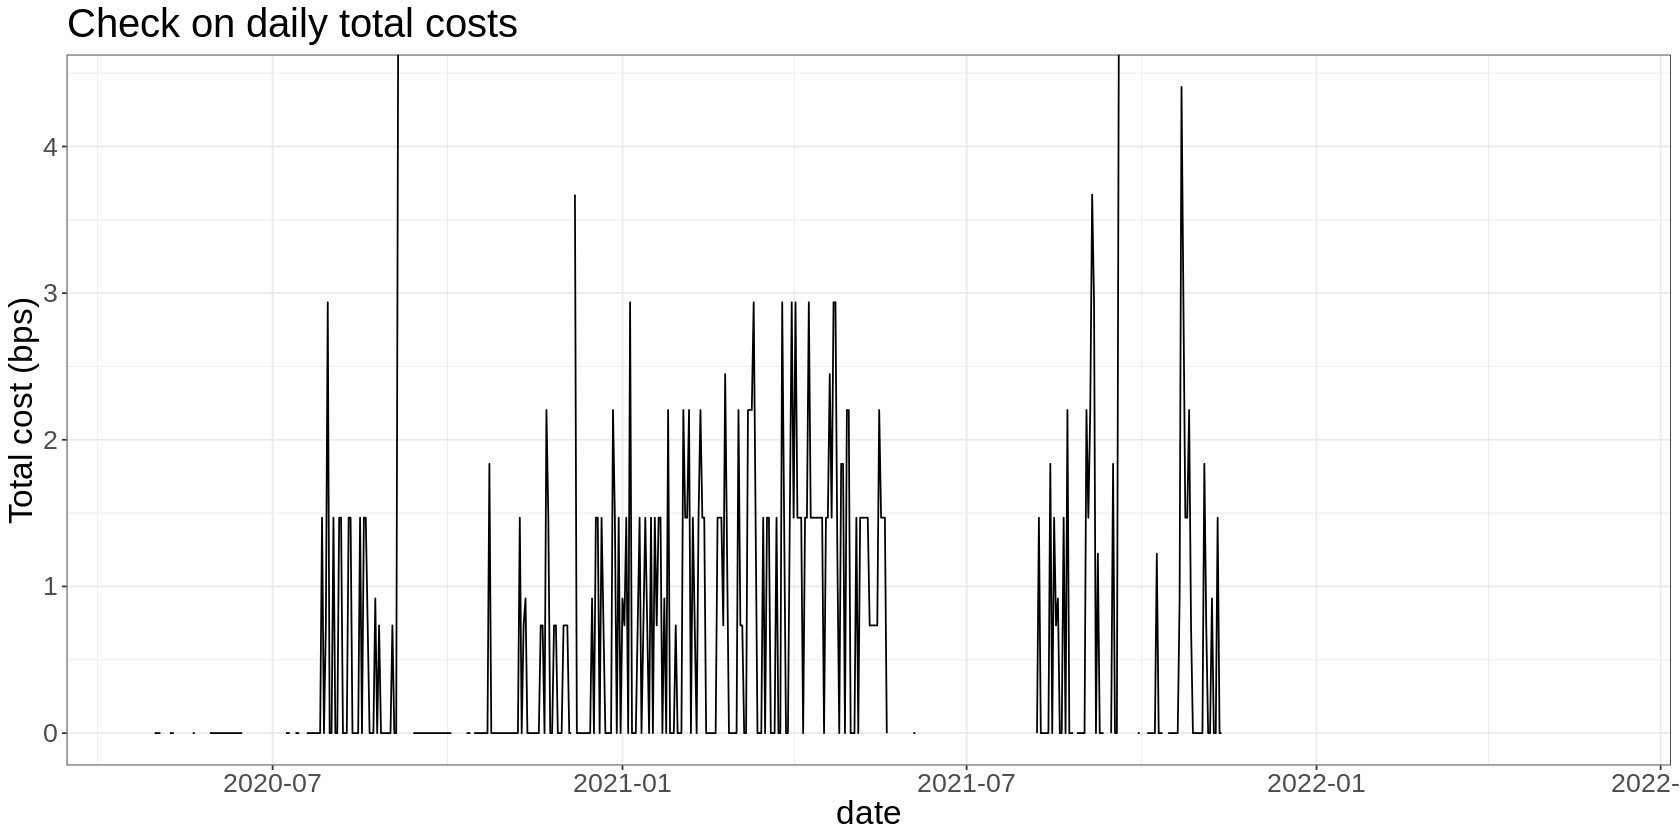

In [35]:
backtest_df %>%
  group_by(date) %>%
  summarise(
    num_positions = sum(pos),
    tot_cost = sum(costs)/num_positions) %>%
  ggplot(aes(x = date, y = tot_cost*10000)) +
    geom_line() + 
    labs(
      title = "Check on daily total costs",
      y = "Total cost (bps)"
    )

Next we'll simulate pnl to our simple perp basis funding strategy.

We could calculate the number of basis points accumulated by holding various positions, but I think it's easier to reason about if we assume that we allocate a certain constant dollar amount to the strategy and calculate pnl in dollars. 

In [36]:
capital <- 1000

results_df <- backtest_df %>%
  group_by(date) %>%
  summarise(
    num_positions = sum(pos),
    diff_pos = sum(diff_pos),
    # pnl to being equal weight in the short perp positions (half our capital is in perps)
    perp_pnl = case_when(num_positions > 0 ~ sum(-pos*fwd_return_perp*capital/(2*top_n), na.rm = TRUE), TRUE ~ 0.),
    # pnl to being equal weight in the long spot positions (half our capital is in spot)
    spot_pnl = case_when(num_positions > 0 ~ sum(pos*fwd_return_spot*capital/(2*top_n), na.rm = TRUE), TRUE ~ 0.),
    # pnl from change in basis
    basis_change_pnl = (perp_pnl + spot_pnl),
    # pnl from funding on positions (we get funding on the half of our capital which is short perps)
    funding_pnl = case_when(num_positions > 0 ~ sum(pos*fwd_funding*capital/(2*top_n)), TRUE ~ 0.),
    # costs accrue proportionally to each position change (noting no minimum commission)
    # costs = case_when(diff_pos > 0 ~ -sum(costs*capital*(diff_pos/num_positions), na.rm = TRUE), TRUE ~ 0.),
    costs = sum(-costs*diff_pos, na.rm = TRUE)*capital/top_n,
    total_pnl = basis_change_pnl + funding_pnl + costs
  )

tail(results_df, 10)

date,num_positions,diff_pos,perp_pnl,spot_pnl,basis_change_pnl,funding_pnl,costs,total_pnl
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2022-05-20,0,0,0,0,0,0,0,0
2022-05-21,0,0,0,0,0,0,0,0
2022-05-22,0,0,0,0,0,0,0,0
2022-05-23,0,0,0,0,0,0,0,0
2022-05-24,0,0,0,0,0,0,0,0
2022-05-25,0,0,0,0,0,0,0,0
2022-05-26,0,0,0,0,0,0,0,0
2022-05-27,0,0,0,0,0,0,0,0
2022-05-28,0,0,0,0,0,0,0,0


Check for NA in our results_df:

In [37]:
map_df(results_df, function(x) sum(is.na(x)))

date,num_positions,diff_pos,perp_pnl,spot_pnl,basis_change_pnl,funding_pnl,costs,total_pnl
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0


Plot time series of daily pnl to each component (change in basis, funding, and costs):

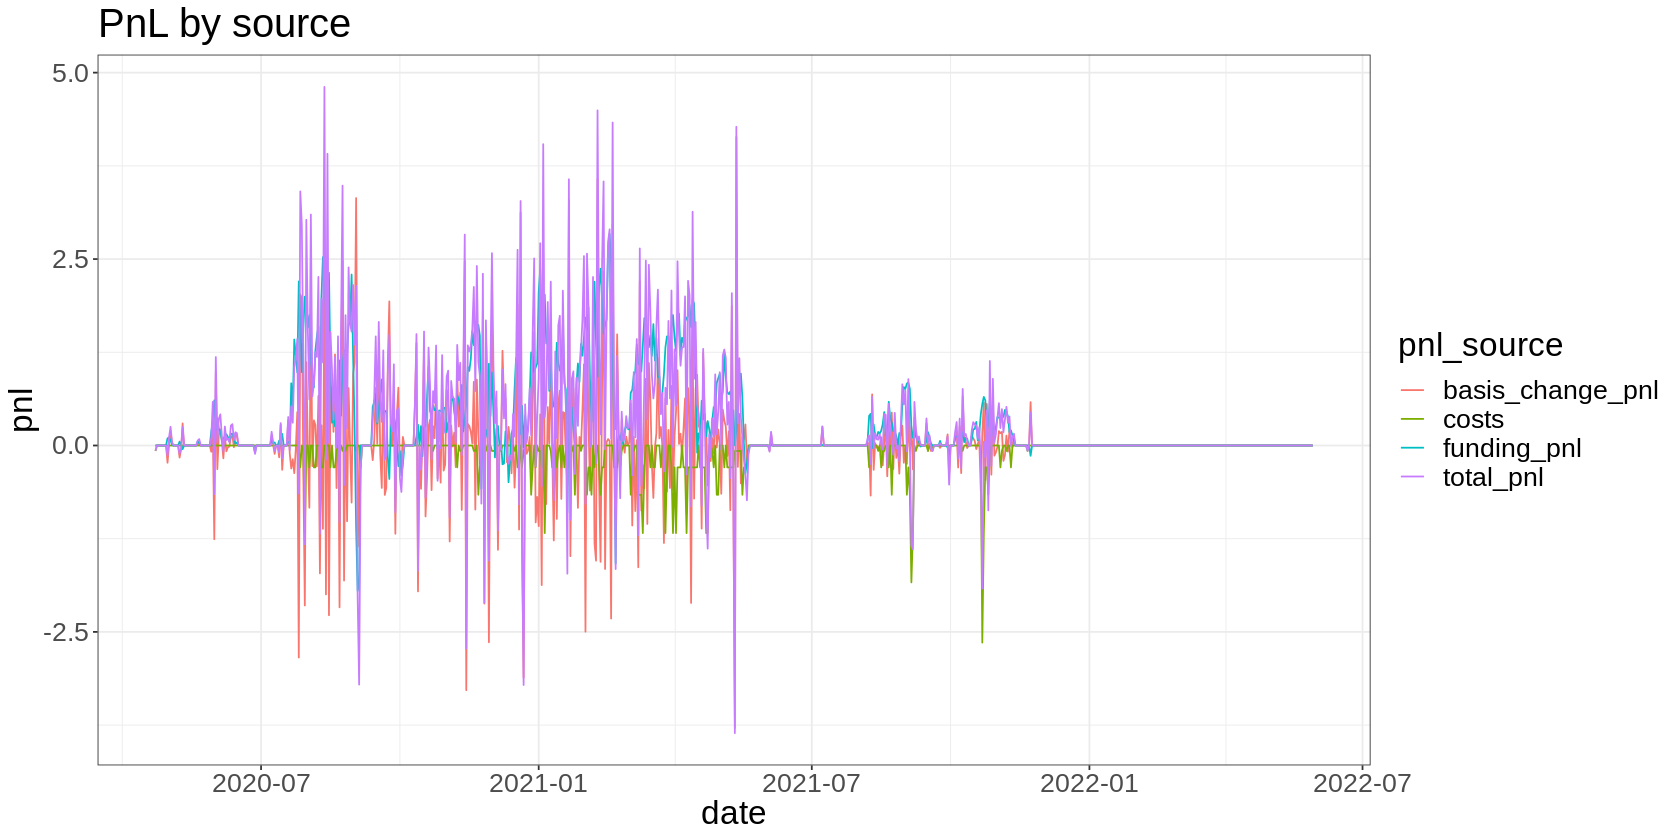

In [38]:
results_df %>%
  select(date, basis_change_pnl, funding_pnl, costs, total_pnl) %>%
  pivot_longer(-date, names_to = "pnl_source", values_to = "pnl") %>%
  ggplot(aes(x = date, y = pnl, colour = pnl_source)) +
    geom_line() +
    labs(title = "PnL by source")

Observe that most of the return comes from funding (purple line tracks the blue line, mostly). 

Next we'll plot cumulative pnl to each source, as well as total pnl to the strategy:

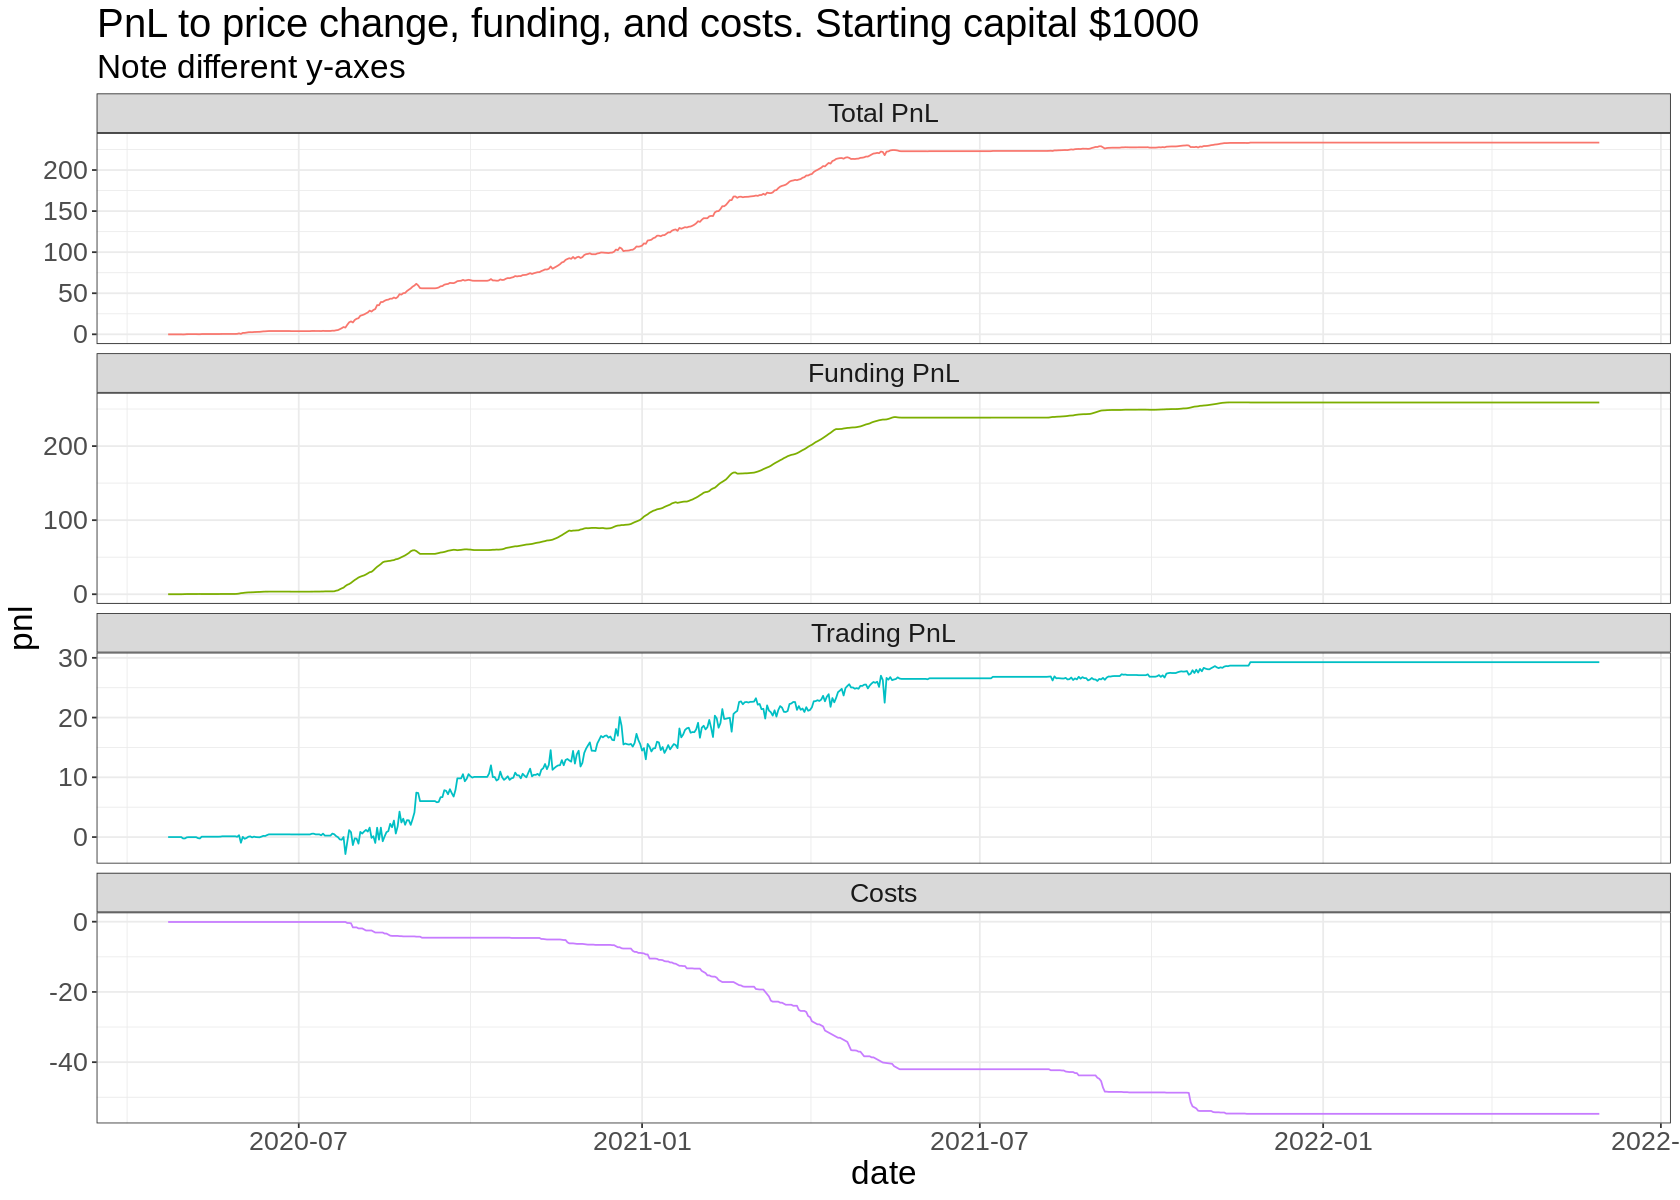

In [39]:
options(repr.plot.width = 14, repr.plot.height=10)

results_df %>%
  mutate(
    `Trading PnL` = cumsum(basis_change_pnl),
    `Funding PnL` = cumsum(funding_pnl),
    Costs = cumsum(costs),
    `Total PnL` = cumsum(total_pnl)
  ) %>%
  select(date, `Trading PnL`, `Funding PnL`, Costs, `Total PnL`) %>%
  pivot_longer(-date, names_to = "pnl_source", values_to = "pnl") %>%
  mutate(pnl_source = factor(pnl_source, levels = c("Total PnL", "Funding PnL", "Trading PnL", "Costs"))) %>%
  ggplot(aes(x = date, y = pnl, colour = pnl_source)) +
    geom_line() +
    facet_wrap(~pnl_source, scales = "free_y", ncol = 1) +
    labs(
      title = glue("PnL to price change, funding, and costs. Starting capital ${capital}"),
      subtitle = "Note different y-axes"
    ) +
    theme(legend.position = "none") 

options(repr.plot.width = 14, repr.plot.height=7)

Calculate some performance metrics:

In [40]:
results_df %>%
  summarise(
    Ann.Return = mean(total_pnl)*365/capital,
    Ann.Vol = sd(total_pnl/capital)*sqrt(365),
    Ann.Sharpe = Ann.Return/Ann.Vol
  ) %>%
  mutate(across(.cols = everything(), .fns = ~ round(.x, 3)))

Ann.Return,Ann.Vol,Ann.Sharpe
<dbl>,<dbl>,<dbl>
0.111,0.017,6.656


### Summary of strategy rules and simulation assumptions

**Rules:**
- Your universe consists of the perps for which there is an equivalent spot market on FTX, and which meet the maximum average spread cutoff. Here's the list:  

`GMT,DOGE, FTT, LTC, AVAX, DOT, NEAR, FTM, KNC, MANA, SAND, AXS, HT, GALA, BTC, ETH, ATOM, LINK, MATIC, SOL, SUSHI, RUNE, BCH, TRX`

- For each perpetual, calculate the mean funding rate over the last three days. This is available at [ftxpremiums.com](https://ftxpremiums.com)
- The hurdle for the mean three-day funding rate is 30%pa. That is, we only consider trading perpetuals whose **mean three-day funding rate is at least 30%pa**.
- Remove any perpetuals that don't meet this criterion.
- Rank your universe of remaining perpetuals by their mean three-day funding.
- Take **up to** the top 5 perpetuals for trading - sometimes there will be fewer than 5 that meet your funding rate criterion. That's OK.
- Allocate an **equal dollar amount** into each tradeable spread.
- Update the model and positions daily. 
- Note that if you have four spreads on day 1, and then on day 2 a fifth spread becomes viable according to your fudning rate criterion, you would sell down an equal amount of each existing postion and put that capital into the fifth. That way, all your capital is deployed whenever there is at least one spread available for trading.
- Likewise, if on day 1 you had 5 positions, and then on day 2 one of those dropped out and wasn't replaced (ie you now only have 4 viable spreads), you would sell that position and allocate the freed up capital equally into the remaining 4 viable spreads.

**Simulation assumptions and where they might break down:**
- 0.07% taker commission
- 0.02% maker commission
- same spread on spot and perp
- Trading happens at the closing price of each day, where each day ends at midnight UTC. We saw that executing throughout the morning UTC could lower the execution cost.

**A "bettter" rule**
- In reality, it wouldn't make sense to trade out of a positive expected value spread and into a new one just because the new one was slightly more positive than the old one. The costs of doing so are significant in proportion to the size of the edge. 
- Instead, use judgement and err on the side of sticking with existing positions until they're predicted to be negative EV, or another spread is predicted to be *significantly* higher EV.


